In [2]:
import pandas as pd 
import numpy as np 
import datetime
from pathlib import Path
import matplotlib as mpl 
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.dates import DateFormatter, MO, TU, WE, TH, FR, SA, SU
from matplotlib.ticker import MaxNLocator
from matplotlib import lines
from matplotlib import patches
from matplotlib import rc
from matplotlib.patheffects import withStroke
import copy
from flexitext import flexitext
mpl.rcParams.update(mpl.rcParamsDefault)

fpath = Path(mpl.get_data_path(), "georgia.ttf")

numbers = pd.read_excel('Numbers.xlsx', skiprows=2, sheet_name='Sheet1')
numbers = numbers[0:len(numbers) - 1]

dates = list(numbers['Year'])
total_revenue = list(numbers['Revenue'])
social_security = list(numbers['Social Security'])
medicare = list(numbers['Medicare'])
medicaid = list(numbers['Medicaid, CHIP, and Marketplace Subsidies'])
other = list(numbers['Other '])
total_spending_ni = list(numbers['Total Noninterest Spending '])
interest = list(numbers['Net Interest'])

total_spending = list(numbers['Total Noninterest Spending '] + numbers['Net Interest'])
# Allows us to place labels

## Useful functions 

def add_label(x, y, text, color, path_effects, rotation, ax, fontsize=18, fontweight='normal'):
    ax.text(x, y, text, color=color,
        fontsize=fontsize, 
        va="center", ha="left", 
        path_effects=path_effects, 
        rotation=rotation, 
        fontweight=fontweight) 
    
def create_yticks(lower, upper, n_ticks):
    tick_width = (upper - lower) / n_ticks
    myticks = [lower]
    for _ in range(n_ticks - 1):
        new_tick = tick_width + lower
        myticks.append(new_tick)
        lower = new_tick 
    return myticks

def filtered_stackplot_data(df:'DataFrame', columns:list, threshold:float=0.05) -> 'tuple of data and labels':
    ''' Function for helping us group together small policies for stackplots'''
    
    others_col = pd.Series(np.zeros(len(df.index)))
    total_sum = df[columns].abs().sum().sum()
    out_columns = []
    out_data = []
    
    for col in columns:
        if (df[col].abs().sum() / total_sum) > threshold:
            out_columns.append(col)
            out_data.append(list(df[col]))
        else:
            others_col += df[col]
            
    out_data.append(list(others_col)) 
    out_columns.append('Other')
    
    return (out_data, out_columns)


def clean_labels(labels:list, desired_line_length=40):
    ''' Needs to be fixed '''
    new_labels = []
    for label in labels:
        if len(label) < desired_line_length:
            new_labels.append(label)
        else:
            white_space = len(label) % desired_line_length * ' '
            new_line_positions = [desired_line_length * i for i in range(len(label) // desired_line_length) if i != 0]
            white_spaces = [idx for idx, item in enumerate(label.lower()) if ' ' in item]
            #print(white_spaces)
            new_white_spaces = []
            for break_point in new_line_positions:
                if label[break_point] == " ":
                    new_white_spaces.append(break_point)
                else:
                    closest_i = min(range(len(white_spaces)), key=lambda i: abs(white_spaces[i] - break_point))
                    #print(break_point, white_spaces[closest_i], label)
                    new_white_spaces.append(white_spaces[closest_i])
        new_label = ''
        for i in range(len(label)):
            if i in new_white_spaces:
                new_label += '\n' #+  ' ' * (i % desired_line_length) 
            else:
                new_label += label[i]
        new_labels.append(new_label)

    return new_labels
    


def mympl(vertical_chart=True, backround_color='#e8e8e8', font_family="serif"):
    
    if vertical_chart:
        mpl.rcParams['axes.spines.right'] = False
        mpl.rcParams['axes.spines.left'] = False
        mpl.rcParams['axes.spines.top'] = False
    else:
        mpl.rcParams['axes.spines.right'] = True
        mpl.rcParams['axes.spines.left'] = False
        mpl.rcParams['axes.spines.top'] = False
        mpl.rcParams['axes.spines.bottom'] = False
            
    mpl.rcParams['figure.facecolor'] = backround_color
    mpl.rcParams["axes.facecolor"] = backround_color
    mpl.rcParams["font.family"] = font_family
    mpl.rcParams["text.color"] = "#174978"

    
    
mympl()


## PLEASE USE THESE COLORS ! 
BROWN = "#AD8C97"
BROWN_DARKER = "#7d3a46"
GREEN = "#2FC1D3"
BLUE = "#076FA1"
GREY = "#C7C9CB"
GREY_DARKER = "#5C5B5D"
RED = "#E3120B"
YELLOW = '#F9C31F'
MIDGREEN = '#91b8bd'
GRIDLINE_COLOR = "#A8BAC4"

path_effects = [withStroke(linewidth=10, foreground="white")]
figsize = (12, 7)

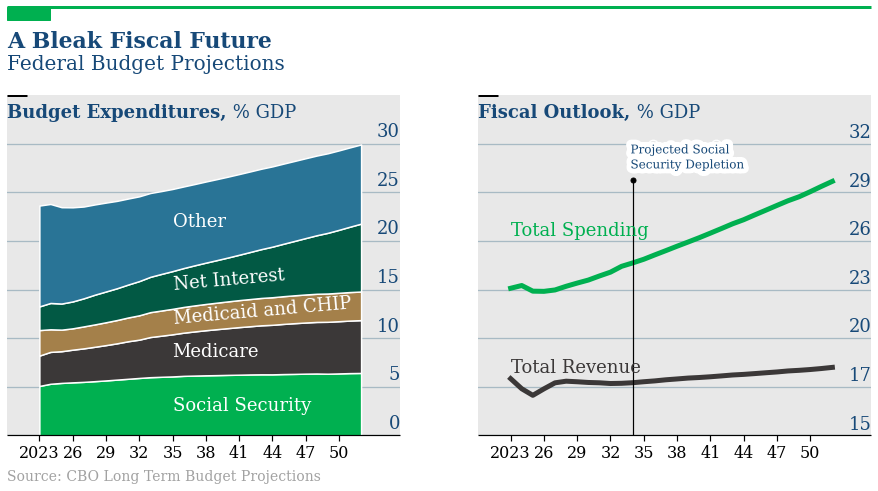

In [3]:
fig, axes = plt.subplots(1, 2, figsize=figsize)
fig.subplots_adjust(left=0, right=1)
# Set up color order
COLORS = ['#00B050', '#3B3838', '#A4804A', '#025944', '#297496']
## Create our axes with the correct tiksetup for both charts
n_ticks = 3
x_max = 2055.5
number_y_ticks = 7
for ax in axes:
    ax.set_axisbelow(True)
    # Format X and Y ticks 
    # We only only want every fourth tick
    dateticks = dates[0::n_ticks]
    ax.xaxis.set_ticks(dateticks)
    label_dates = [2023] + [int(float(str(mydate)[2:])) for mydate in dateticks if mydate != 2023]
    ax.xaxis.set_ticklabels(label_dates, fontsize=16, fontweight=100)
    ax.xaxis.set_tick_params(length=6, width=1.2)
    ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
    # Remove all spines but the one in the bottom
    # Customize bottom spine
    # We want to make the bottom spine bolder.
    ax.spines["bottom"].set_lw(1.2)
    ax.spines["bottom"].set_capstyle("butt")
    ax.yaxis.set_tick_params(labelleft=False, length=0)
    ax.set_xlim(2020.1, x_max)
  
##################################################### Plot One 
y_max = 35
# Set y limits
axes[0].set_ylim(0, y_max)
# Setting the yticks are important for formatting further down
axes[0].yaxis.set_ticks([i * y_max / number_y_ticks for i in range(0, number_y_ticks)])
axes[0].yaxis.set_tick_params(labelleft=False, length=0)

# Pad between ytick label and y line
PAD = y_max * 0.02
for label in [int(i * y_max / number_y_ticks) for i in range(0, number_y_ticks)]:
    axes[0].text(x_max, label + PAD, label, ha="right", va="baseline", fontsize=18, fontweight=100)

stackplot_data = [social_security, medicare, medicaid, interest, other]
axes[0].stackplot(dates, stackplot_data, colors=COLORS, lw=1.5, edgecolor='white')

labels = [
    {"x": 2035, "y": 3, "text": "Social Security", "color": 'white', "path_effects":[], 'rotation':0},
    {"x": 2035, "y": 8.6, "text": "Medicare", "color": "white", "path_effects":[], 'rotation':0},
    {"x": 2035, "y": 12.8, "text": "Medicaid and CHIP", "color": "white", "path_effects":[], 'rotation':5},
    {"x": 2035, "y": 16, "text": "Net Interest", "color": 'white', "path_effects":[], 'rotation':5},
    {"x": 2035, "y": 22, "text": 'Other', "color": 'white', "path_effects":[], 'rotation':0}]    

for label in labels:
    add_label(**label, ax=axes[0])
    
text = "<name:serif, size:18><weight:bold>Budget Expenditures,</> % GDP</>"
flexitext(0, 0.975, text, va="top", ax=axes[0])
axes[0].add_artist(lines.Line2D([0, 0.05], [1, 1], lw=3, color="black", solid_capstyle="butt", transform=axes[0].transAxes))

######################################################################## Second Plot
gov_series = [total_spending, total_revenue]
for series, color in zip(gov_series, COLORS):
    axes[1].plot(dates, series, color=color, lw=5)
    #axes[1].scatter(dates, series, fc=color, s=100, lw=1.5, ec="white", zorder=12)

axes[1].plot([2034, 2034],[0, 30], color='black', marker='.', ms=10, markevery=[-1], lw=1.2)
axes[1].text(2033.8, 30.7, 'Projected Social\nSecurity Depletion', va="baseline", fontsize=12, fontweight=100, path_effects=path_effects)  
    
y_max = 35
y_min = 15
# Set y limits
axes[1].set_ylim(y_min, y_max)  
myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
axes[1].yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0.01
for label in myticks:
    axes[1].text(x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, 
    fontweight=100)   
      
# Add title
text = "<name:serif, size:18><weight:bold>Fiscal Outlook,</> % GDP</>"
flexitext(0, 0.975, text, va="top", ax=axes[1])
axes[1].add_artist(lines.Line2D([0, 0.05], [1, 1], lw=3, color='black', solid_capstyle="butt", transform=axes[1].transAxes))

labels = [
    {"x": 2023, "y": 27, "text": 'Total Spending', "color": "#00B050", "path_effects":[], 'rotation':0},
    {"x": 2023, "y": 19, "text": "Total Revenue", "color": COLORS[1], "path_effects":[], 'rotation':0}] 

for label in labels:
    add_label(**label, ax=axes[1])
    
# ########################################################## Final Figure Touches

## Add in sources 
fig.subplots_adjust(top=0.825, bottom=0.15)

source = 'Source: CBO Long Term Budget Projections'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14)
    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color="#00B050"))

# Add title
fig.text(0, 0.92, "A Bleak Fiscal Future", fontsize=22,fontweight="bold")
# Add subtitle
fig.text(0, 0.875, "Federal Budget Projections", fontsize=20)

plt.savefig('bleak_future.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

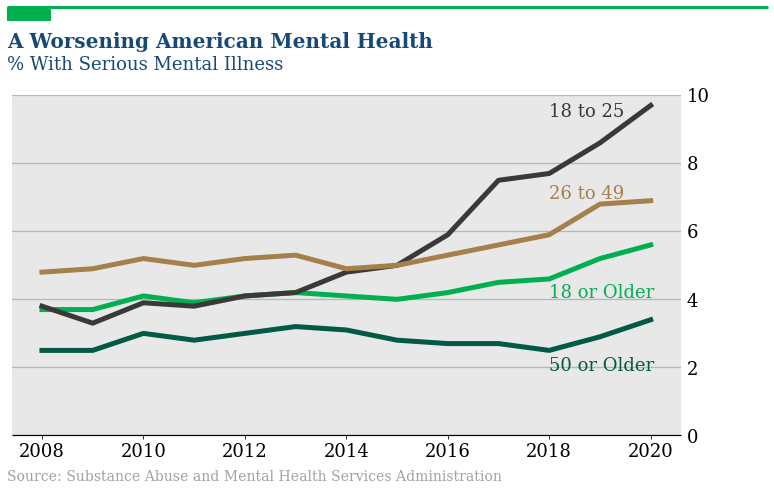

In [4]:
mental_health_df = pd.read_csv('mental_health.csv')
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.plot(mental_health_df['Years'], 
        mental_health_df['18 or Older'], 
        color='#00B050',
        linewidth=5)
ax.plot(mental_health_df['Years'], 
        mental_health_df['18 to 25'], 
        color='#3B3838',
        linewidth=5)
ax.plot(mental_health_df['Years'], 
        mental_health_df['26 to 49'], 
        color='#A4804A',
        linewidth=5)
ax.plot(mental_health_df['Years'], 
        mental_health_df['50 or Older'], 
        color='#025944',
        linewidth=5)

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 10)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 



labels = [
    {"x": 2018, "y": 4.2, "text": '18 or Older', "color": '#00B050', "path_effects":[], 'rotation':0},
    {"x": 2018, "y": 9.5, "text": "18 to 25", "color": '#3B3838', "path_effects":[], 'rotation':0},
    {"x": 2018, "y": 7.1, "text": "26 to 49", "color": '#A4804A', "path_effects":[], 'rotation':0},
    {"x": 2018, "y": 2.05, "text": "50 or Older", "color": '#025944', "path_effects":[], 'rotation':0}] 

for label in labels:
    add_label(**label, ax=ax)

source = 'Source: Substance Abuse and Mental Health Services Administration'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "A Worsening American Mental Health", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "% With Serious Mental Illness", fontsize=18)
plt.savefig('mental_health.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

In [5]:
transit_df = pd.read_csv('transit.csv')
transit_df = transit_df.replace(',','', regex=True)
transit_df["Unlinked Passanger Trips ( Millions)"] = pd.to_numeric(transit_df["Unlinked Passanger Trips ( Millions)"])
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
# ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.plot(transit_df['Year'], 
        transit_df['Unlinked Passanger Trips ( Millions)'], 
        color='#00B050',
        linewidth=5)

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")


ax.xaxis.set_tick_params(labelsize=18)
ax.set_ylim(9600, 11000)



ax.yaxis.set_tick_params(pad=2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 




source = 'Source: American Public Transportation Association'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Public Transit Out Of Favor", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Unlinked Passenger Trips (Millions)", fontsize=18)
plt.savefig('public_transit.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

KeyError: KeyError: 'Unlinked Passanger Trips ( Millions)'

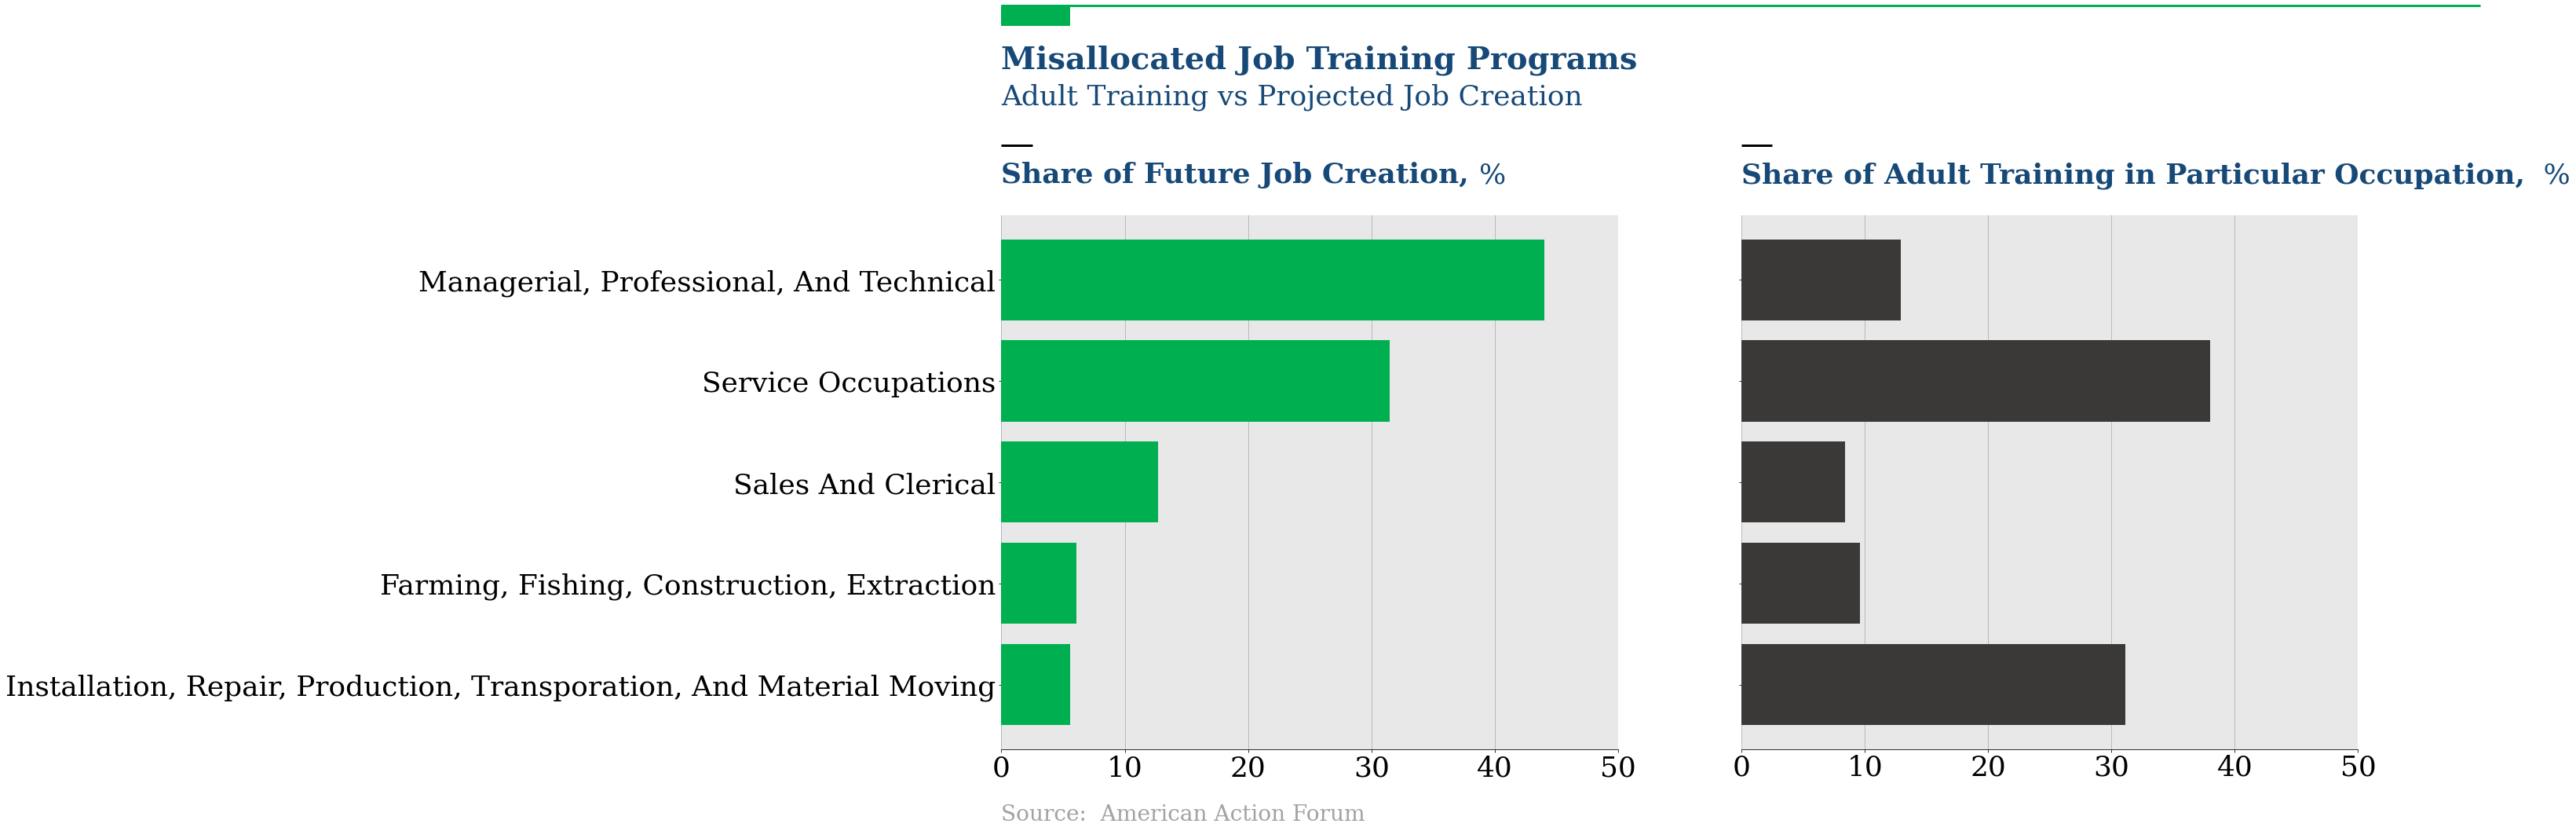

In [6]:
workforce_df = pd.read_csv('Workforce.csv')
workforce_df = workforce_df.replace('%','', regex=True)
workforce_df["Share of Future Job Creation, %"] = pd.to_numeric(workforce_df["Share of Future Job Creation, %"])
workforce_df["Share of Adult Training in Particular Occupation, %"] = pd.to_numeric(workforce_df["Share of Adult Training in Particular Occupation, %"])
workforce_df = workforce_df[::-1]
workforce_df['Occupational Group'] = workforce_df['Occupational Group'].str.title()
fig, axes = plt.subplots(1, 2, figsize=(24, 14), sharey=True)
#fig.subplots_adjust(top=0.825, bottom=0.15)
fig.subplots_adjust(left=0, right=1)
axes[0].set_axisbelow(True)
axes[0].grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
axes[0].barh(workforce_df['Occupational Group'], workforce_df['Share of Future Job Creation, %'],  color='#00B050')
x_max = 50
x_min = 0
# Set y limits
axes[0].set_xlim(x_min, x_max)  

# Pad between ytick label and y line
axes[0].xaxis.set_tick_params(labelsize=18*2)
axes[0].yaxis.set_tick_params(labelsize=18*2)







axes[1].barh(workforce_df['Occupational Group'], workforce_df['Share of Adult Training in Particular Occupation, %'],  color='#3B3838')
axes[1].set_axisbelow(True)
axes[1].grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
x_max = 50
x_min = 0
# Set y limits
axes[1].set_xlim(x_min, x_max)  

# Pad between ytick label and y line
axes[1].xaxis.set_tick_params(pad=2,             # Pad tick labels so they don't go over y-axis
                         labeltop=False,      # Put x-axis labels on top
                         labelbottom=True,  # Set no x-axis labels on bottom
                         bottom=True,       # Set no ticks on bottom
                         labelsize=18*2)
axes[1].yaxis.set_tick_params(labelsize=18*2) 

fig.add_artist(lines.Line2D([0, 0.05], [1.13, 1.13], lw=3, color="black", solid_capstyle="butt", transform=axes[0].transAxes))    
text = "<name:serif, size:36><weight:bold>Share of Future Job Creation, </>%</>"
flexitext(0, 1.1, text, va="top", ax=axes[0])

fig.add_artist(lines.Line2D([0, 0.05], [1.13, 1.13], lw=3, color="black", solid_capstyle="butt", transform=axes[1].transAxes))    
text = "<name:serif, size:36><weight:bold>Share of Adult Training in Particular Occupation, </> %</>"
flexitext(0, 1.1, text, va="top", ax=axes[1])

fig.add_artist(lines.Line2D([0, 1.11 - 0.02], [1.11 - 0.02, 1.11 - 0.02], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.105 - 0.02 * 2), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)

fig.text(0, 1.05 - 0.02 * 2, "Misallocated Job Training Programs", fontsize=20*2,fontweight="bold")
# Add subtitle
fig.text(0, 1.005 - 0.02 * 2, "Adult Training vs Projected Job Creation", fontsize=18*2)

source = 'Source:  American Action Forum'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14*2)

plt.savefig('job_training.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

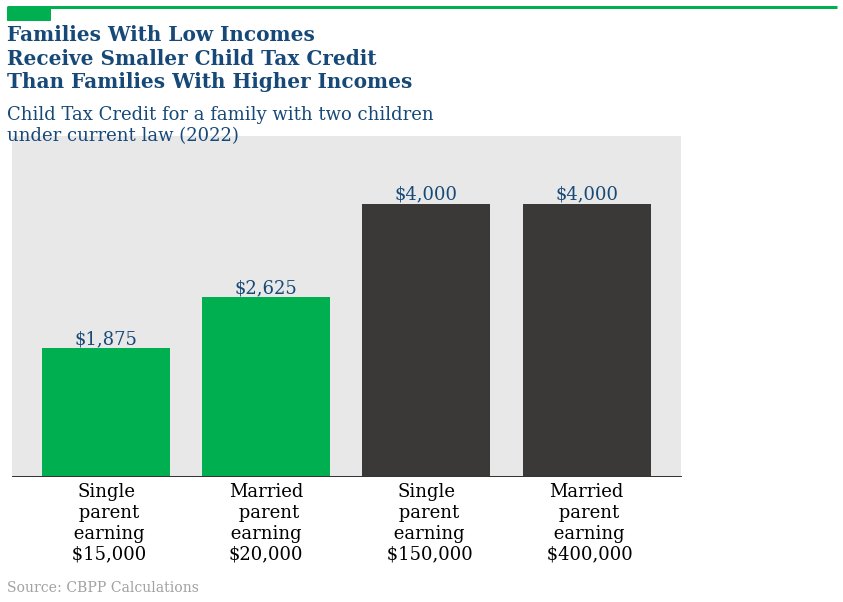

In [7]:
dollar_values = [1875, 2625, 4000, 4000]
text_values = ['Single\n parent\n earning\n $15,000', 'Married\n parent\n earning \n$20,000', 'Single\n parent\n earning\n $150,000', 'Married\n parent\n earning\n $400,000']

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)



ax.bar(text_values[0:2], dollar_values[0:2],  color='#00B050')
ax.bar(text_values[2:4], dollar_values[2:4],  color='#3B3838')
ax.set_ylim(0, 5000)

ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)

ax.xaxis.set_tick_params(labelsize=18)

rects = ax.patches
labels = ['$1,875', '$2,625', '$4,000', '$4,000']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom", fontsize = 18
    )


source = 'Source: CBPP Calculations'
fig.text(0.12, -0.08, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1 + 0.08], [1+ 0.08, 1+ 0.08], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975+ 0.08), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Families With Low Incomes\nReceive Smaller Child Tax Credit\nThan Families With Higher Incomes", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875 - 0.06, "Child Tax Credit for a family with two children\nunder current law (2022)", fontsize=18)

plt.savefig('CTC.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

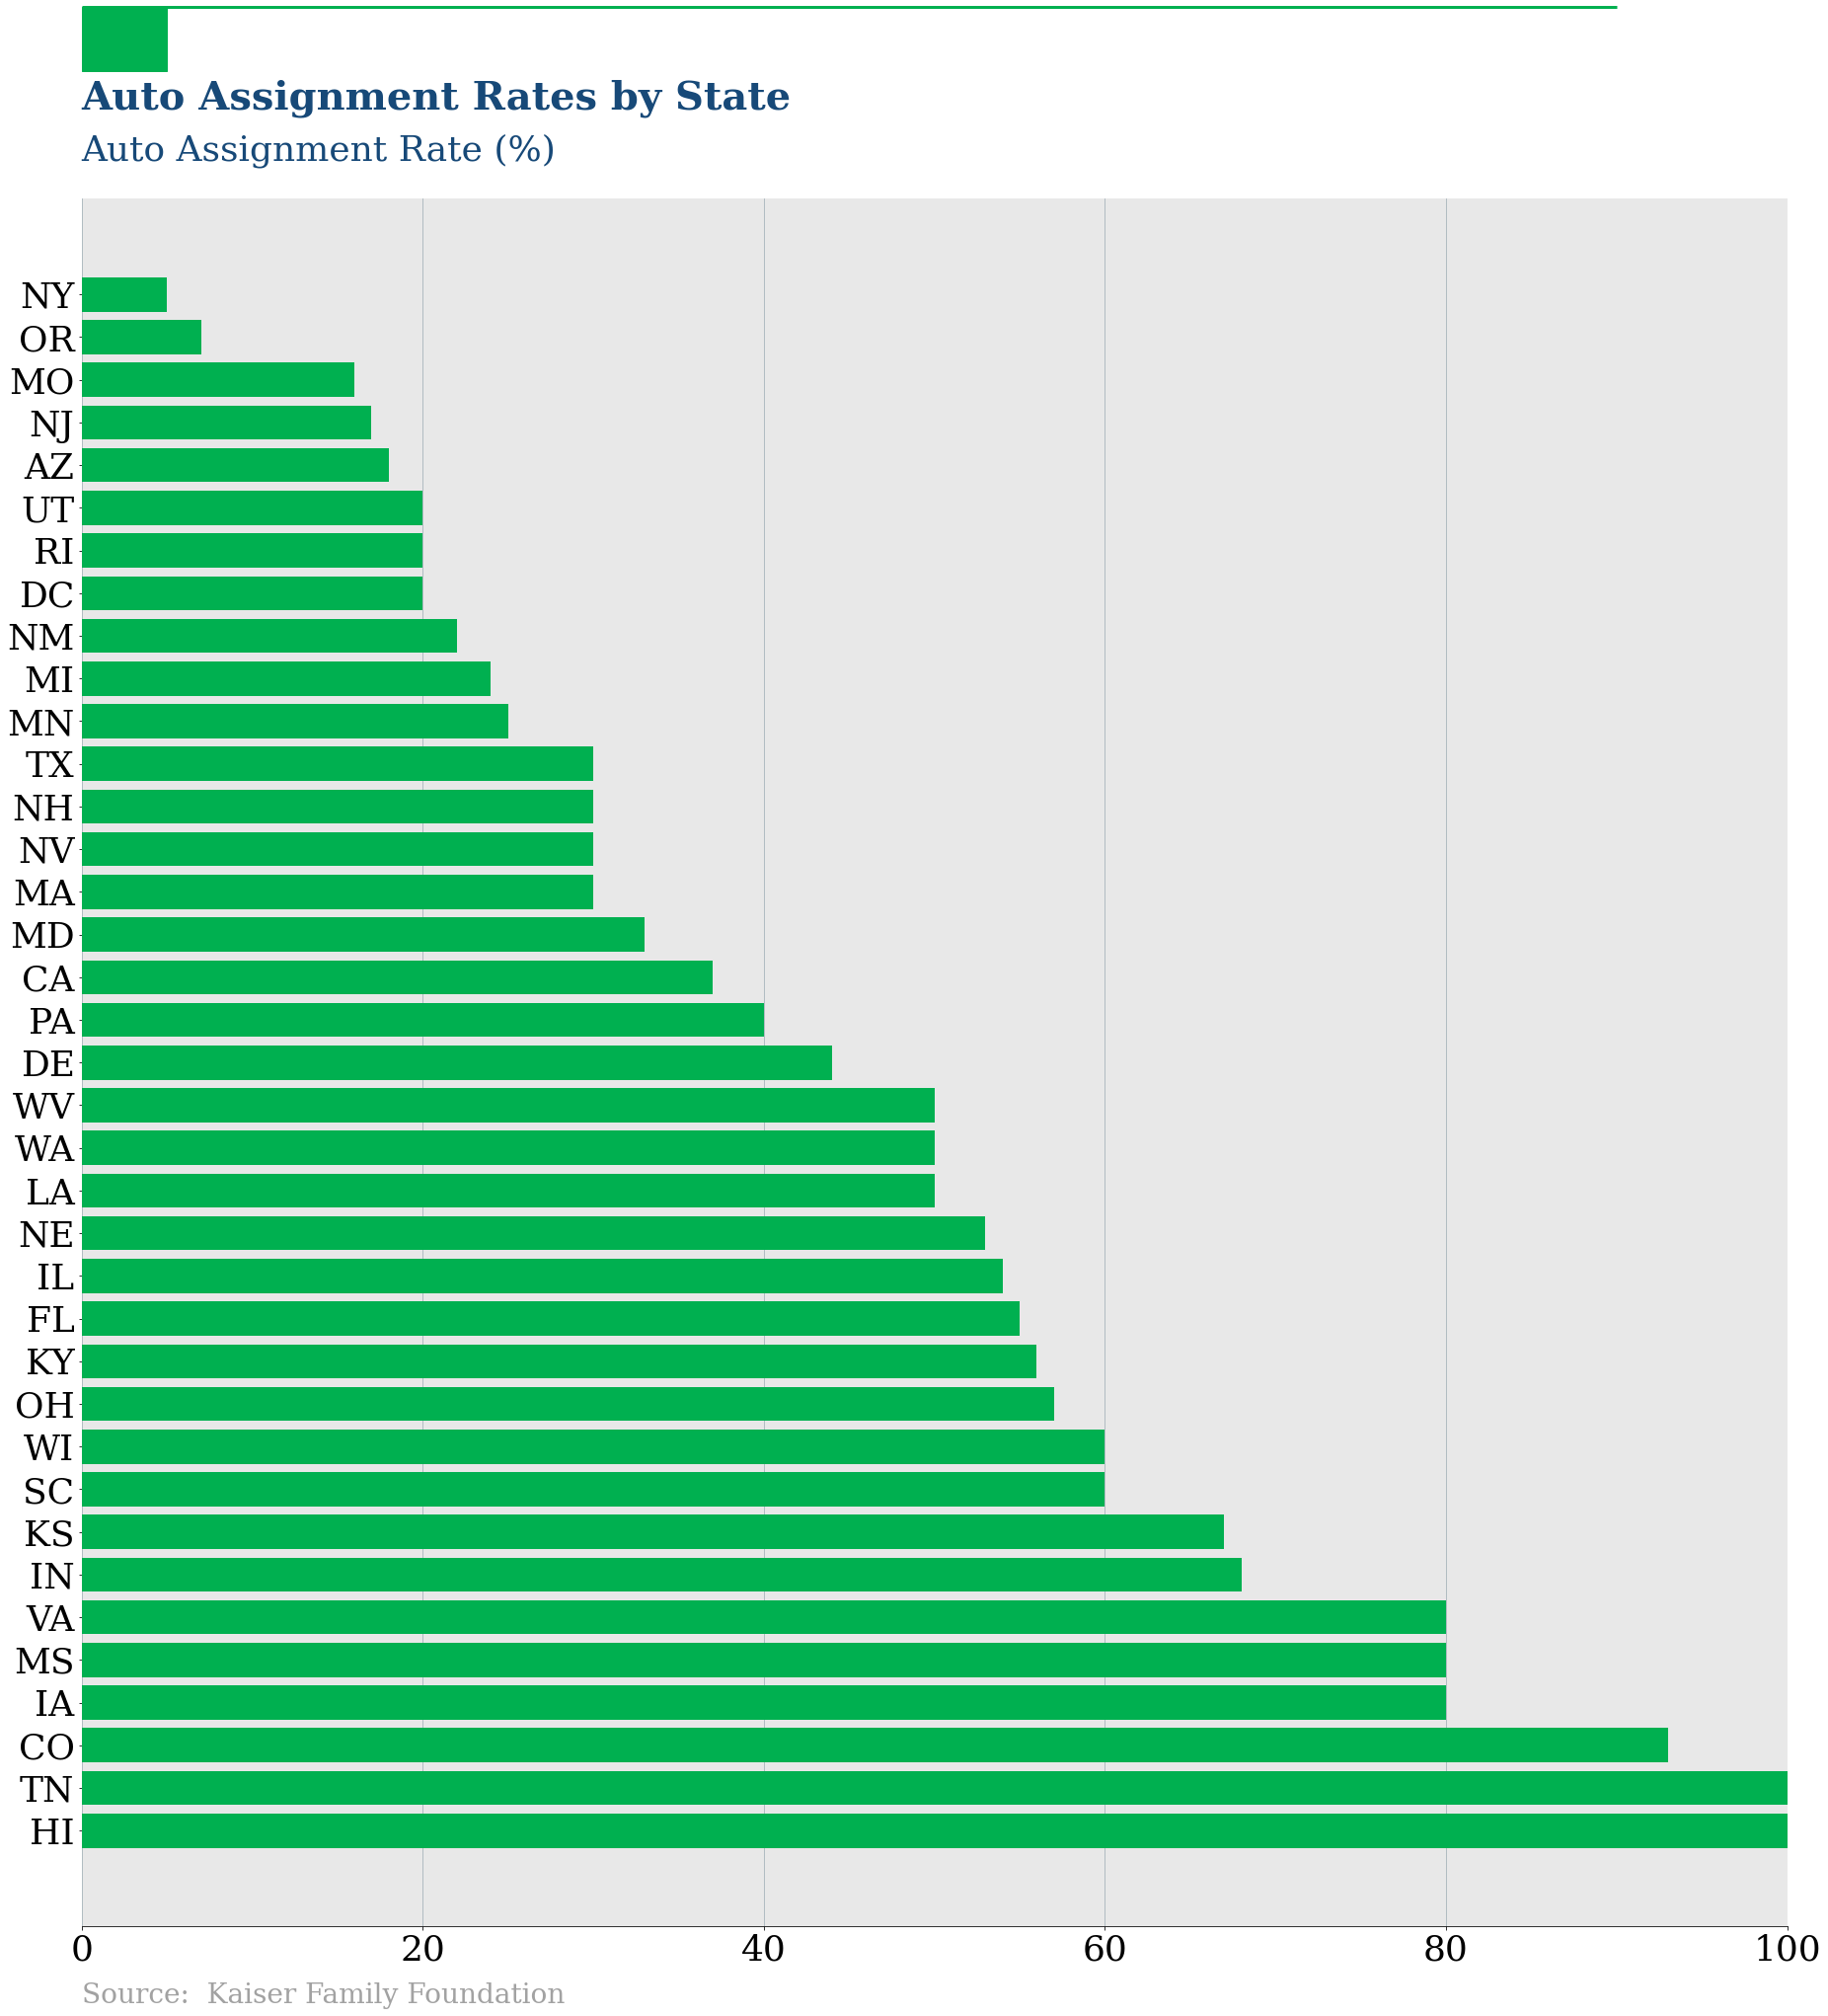

In [8]:
state_codes = ['NY','OR','MO','NJ','AZ','UT','RI','DC','NM','MI','MN','TX','NH','NV','MA','MD','CA','PA','DE','WV','WA','LA','NE','IL','FL','KY','OH','WI','SC','KS','IN','VA','MS','IA','CO','TN','HI']
state_numbers = [5, 7, 16, 17, 18, 20, 20, 20, 22, 24, 25, 30, 30, 30, 30, 33, 37, 40, 44, 50, 50, 50, 53, 54, 55, 56, 57, 60, 60, 67, 68, 80, 80, 80, 93, 100, 100]

fig, ax = plt.subplots(1, 1, figsize=(24, 36), sharey=True)
#fig.subplots_adjust(top=0.825, bottom=0.15)
fig.subplots_adjust(left=0, right=1)
ax.set_axisbelow(True)
ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
ax.barh(state_codes[::-1], state_numbers[::-1],  color='#00B050')
x_max = 100
x_min = 0
# Set y limits
ax.set_xlim(x_min, x_max)  

# Pad between ytick label and y line
ax.xaxis.set_tick_params(labelsize=18*2)
ax.yaxis.set_tick_params(labelsize=18*2)



fig.add_artist(lines.Line2D([0, 1 - 0.1], [1 - 0.1, 1 - 0.1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975 - 0.1), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0, 0.92 - 0.06, "Auto Assignment Rates by State", fontsize=40,fontweight="bold")
# Add subtitle
fig.text(0, 0.875 - 0.035, "Auto Assignment Rate (%)", fontsize=36)

source = 'Source:  Kaiser Family Foundation'
fig.text(0, 0.12, source, color="#a2a2a2", fontsize=14*2)

plt.savefig('auto_assignment.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

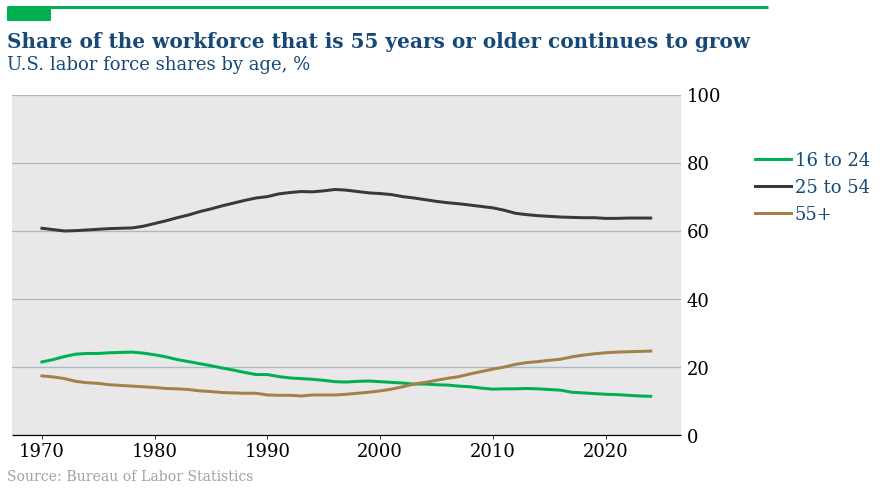

In [9]:
employment_df = pd.read_csv('emp-rates.csv')
employment_df = employment_df.replace('%','', regex=True)
employment_df["Labor force 16 to 24"] = pd.to_numeric(employment_df["Labor force 16 to 24"])
employment_df["Labor force 25 to 54"] = pd.to_numeric(employment_df["Labor force 25 to 54"])
employment_df["Year"] = pd.to_numeric(employment_df["Year"])
employment_df["Labor force 55+"] = pd.to_numeric(employment_df["Labor force 55+"])
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.plot(employment_df['Year'], 
        employment_df['Labor force 16 to 24'], 
        color='#00B050',
        linewidth=3)
ax.plot(employment_df['Year'], 
        employment_df['Labor force 25 to 54'], 
        color='#3B3838',
        linewidth=3)
ax.plot(employment_df['Year'], 
        employment_df['Labor force 55+'], 
        color='#A4804A',
        linewidth=3)


ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 100)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 





source = 'Source: Bureau of Labor Statistics'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#00B050"))
ax.legend(['16 to 24', '25 to 54', '55+'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})

fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Share of the workforce that is 55 years or older continues to grow", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "U.S. labor force shares by age, %", fontsize=18)
plt.savefig('employment_rates.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

<ipython-input-10-f36d4c2646f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_numbers['Quarter'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[1])
<ipython-input-10-f36d4c2646f8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_numbers['Date'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[0])


ValueError: ValueError: operands could not be broadcast together with shapes (33,) (34,) 

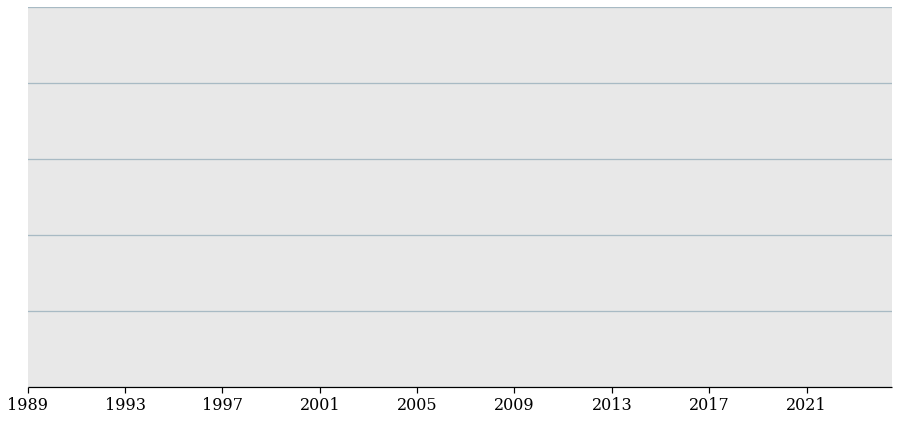

In [10]:
unfiltered_numbers = pd.read_csv('dfa-income-shares.csv')
unfiltered_numbers.keys()
filtered_numbers = unfiltered_numbers[['Date', 'Category', 'Assets']]

filtered_numbers['Quarter'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[1])
filtered_numbers['Date'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[0])
filtered_numbers = filtered_numbers[filtered_numbers['Quarter'] =='Q2']



pct99to100 = filtered_numbers[filtered_numbers['Category'] == 'pct99to100']
pct99to100_l = pct99to100['Assets']

pct80to99 = filtered_numbers[filtered_numbers['Category'] == 'pct80to99']
pct80to99_l = pct80to99['Assets']

pct60to80 = filtered_numbers[filtered_numbers['Category'] == 'pct60to80']
pct60to80_l = pct60to80['Assets']

pct40to60 = filtered_numbers[filtered_numbers['Category'] == 'pct40to60']
pct40to60_l = pct40to60['Assets']

pct20to40 = filtered_numbers[filtered_numbers['Category'] == 'pct20to40']
pct20to40_l = pct20to40['Assets']

pct00to20 = filtered_numbers[filtered_numbers['Category'] == 'pct00to20']
pct00to20_l = pct00to20['Assets']

pct00to40 = pd.DataFrame()
pct00to40['Assets'] = np.array(pct00to20['Assets']) + np.array(pct20to40['Assets'])
pct00to40_l = pct00to40['Assets']

pct40to80 = pd.DataFrame()
pct40to80['Assets'] = np.array(pct40to60['Assets']) + np.array(pct60to80['Assets'])
pct40to80_l = pct40to80['Assets']


# ################################### Graph below 

fig, ax = plt.subplots(1, 1, figsize=figsize)
fig.subplots_adjust(left=0, right=1)

COLORS = ['#00B050', '#3B3838', '#A4804A', '#025944', '#297496']
## Create our axes with the correct tiksetup for both charts
n_ticks = 4
number_y_ticks = 6
x_max = 2024.5
ax.set_axisbelow(True)
# Format X and Y ticks 
# We only only want every fourth tick
dates = [year for year in range(1989, 2022)]
dateticks = dates[0::n_ticks]
ax.xaxis.set_ticks(dateticks)
ax.xaxis.set_ticklabels(dateticks, fontsize=16, fontweight=100)
ax.xaxis.set_tick_params(length=6, width=1.2)
# Remove all spines but the one in the bottom
# Customize bottom spine
# We want to make the bottom spine bolder.
ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_xlim(1989, x_max)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)


stack_data = [pct00to40_l, pct40to80_l, pct80to99_l, pct99to100_l]
ax.stackplot(dates, stack_data, colors=COLORS, lw=1.5, edgecolor='white')

labels = [
    {"x": 1993, "y": 5, "text": "Bottom 40%", "color": "white", "path_effects":[], 'rotation':0},
{"x": 1993, "y": 25, "text": "40% to 80%", "color": "white", "path_effects":[], 'rotation':0},
{"x": 1993, "y": 60, "text": "80% to 99%", "color": "white", "path_effects":[], 'rotation':0},
{"x": 1993.5, "y": 90, "text": "Top 1%", "color": "white", "path_effects":[], 'rotation':0}]    

for label in labels:
    add_label(**label, ax=ax, fontsize=18)

y_max = 120
y_min = 0
# Set y limits
ax.set_ylim(y_min, y_max)  
myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0.02
for label in myticks:
    ax.text(x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, 
    fontweight=100)       


# Add in sources
fig.subplots_adjust(top=0.825, bottom=0.15)
source = 'Source: Federal Reserve'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14)
    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [0.875, 0.875], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.85), 0.05, 0.025, color="#00B050"))

# Add title
fig.text(0, 0.78, "Wealth Inequality Grows", fontsize=22,fontweight="bold")
# Add subtitle
#fig.text(0, 0.875, "Drug Overdoses in the United States", fontsize=20)

text = "<name:serif, size:18><weight:bold>Share of Total Assets, </>%</>"
flexitext(0, 0.88, text, ax=ax)

plt.savefig('wealth.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

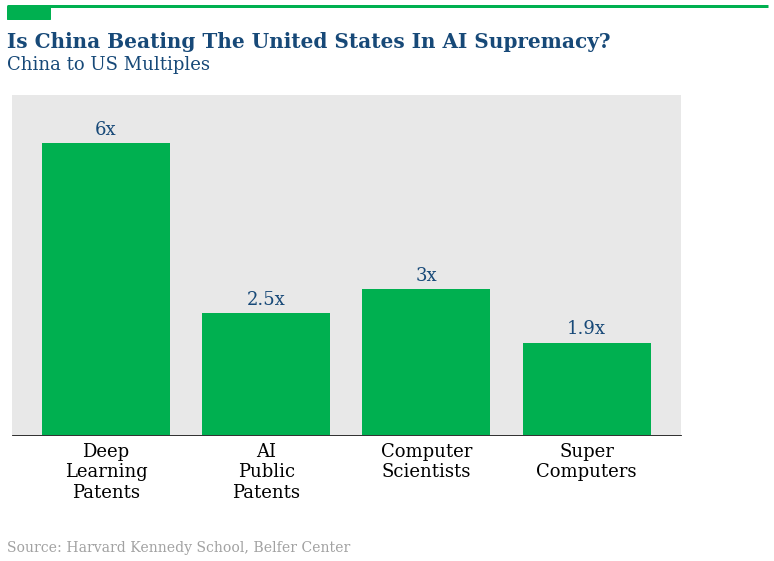

In [11]:
usa_china_df = pd.read_csv('usa-china.csv')
usa_china_df = usa_china_df.replace(' ','\n', regex=True)
usa_china_df['China to USA Multiple'] = pd.to_numeric(usa_china_df['China to USA Multiple'])
num_values = usa_china_df['China to USA Multiple']
text_values = usa_china_df['China & US Comparison']

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)



ax.bar(text_values, num_values,  color='#00B050')

ax.set_ylim(0, 7)

ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)

ax.xaxis.set_tick_params(labelsize=18)

rects = ax.patches
labels = ['6x', '2.5x', '3x', '1.9x']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom", fontsize = 18
    )


source = 'Source: Harvard Kennedy School, Belfer Center'
fig.text(0.12, -0.08, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Is China Beating The United States In AI Supremacy?", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "China to US Multiples", fontsize=18)

plt.savefig('us-china.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

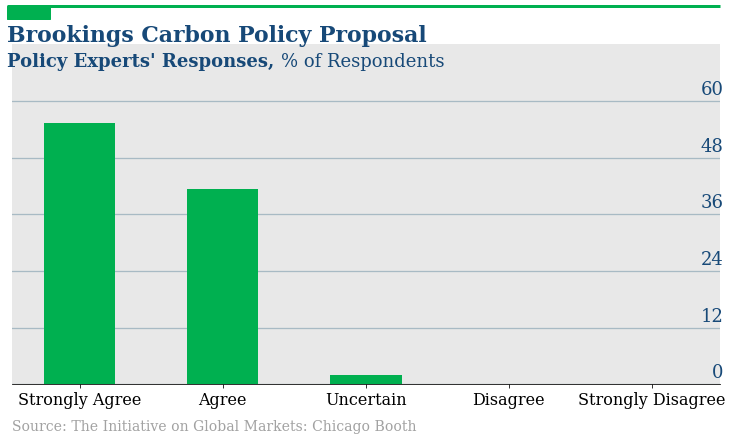

In [12]:
x_axis_names = ['Strongly Agree', 'Agree', 'Uncertain', 'Disagree', 'Strongly Disagree']
x_axis = np.arange(5)
responses = [56, 42, 2, 0, 0]

x_max = 4.5
y_max = 73
y_min = 0
number_y_ticks = 6


bar_width = .5
fig, ax = plt.subplots(figsize=figsize)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3, zorder=0)
first = ax.bar(x_axis, responses, bar_width, color="#00B050", zorder=3)
ax.set_xticks(x_axis)
ax.xaxis.set_ticklabels(x_axis_names, fontsize=16, fontweight=100)
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_ylim(y_min, y_max)

#plt.setp(autotexts, size=16, weight="bold")
fig.subplots_adjust(top=0.825, bottom=0.15, left=.08)
source = 'Source: The Initiative on Global Markets: Chicago Booth'
fig.text(.08, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([.075, .9], [.9, .9], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((.075, .875), 0.05, 0.025, color="#00B050"))

myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0.02
for label in myticks:
    ax.text(x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, 
    fontweight=100)
# Add title
fig.text(.075, 0.83, "Brookings Carbon Policy Proposal", fontsize=22,fontweight="bold")
# Add subtitle
text = "<name:serif, size:18><weight:bold>Policy Experts' Responses, </>% of Respondents</>"
flexitext(-.006, .95, text, ax=ax)

plt.savefig('carbon.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

    Year  Old Debt to GDP Ratio  New Debt to GDP Ratio  \
0   2023                 98.011                  95.47   
1   2024                100.381                  97.31   
2   2025                102.111                  96.15   
3   2026                103.322                  95.24   
4   2027                104.460                  94.19   
5   2028                106.506                  93.93   
6   2029                107.675                  92.69   
7   2030                109.881                  92.73   
8   2031                112.214                  92.88   
9   2032                114.807                  93.38   
10  2033                118.217                  94.50   
11  2034                121.275                  93.82   
12  2035                124.339                  94.14   
13  2036                127.437                  94.34   
14  2037                130.537                  95.03   
15  2038                133.730                  95.47   
16  2039      

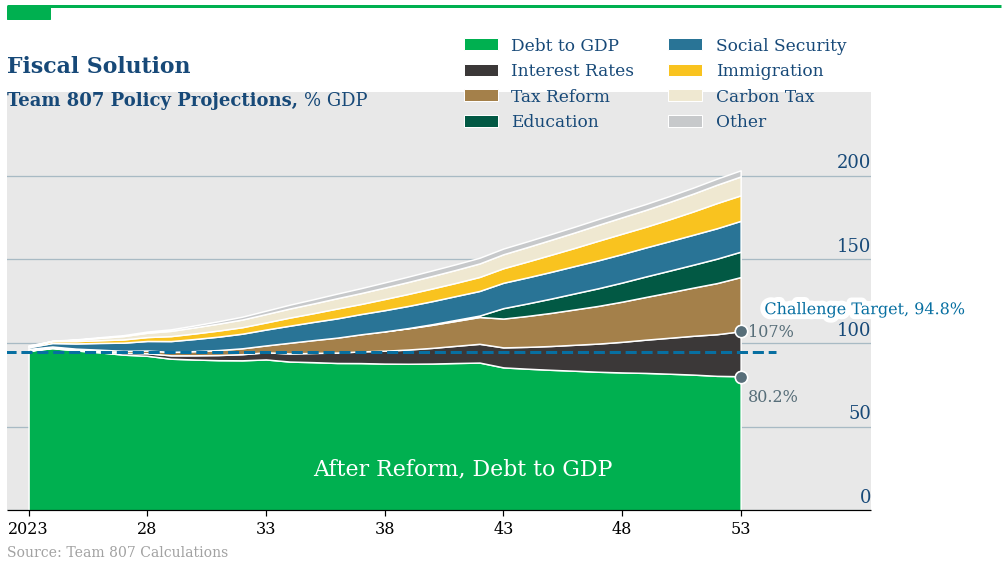

In [13]:
from matplotlib import patches
final_df = pd.read_csv('policy-nums.csv')
final_df = final_df.replace('%','', regex=True)
cols = final_df.columns
final_df[cols] = final_df[cols].apply(pd.to_numeric, errors='coerce')
print(final_df)

policies = ['Public Transit',
            'Auto Assignment',
            'Training',
            'Mental Health',
            'Education',
            'SALT',
            'Muni Bond',
            'Social Security',	
            'Immigration',	
            'CTC',	
            'Step Up Basis',
            'Carbon Tax'	
            'Military']


old = final_df['Old Debt to GDP Ratio']
new = final_df['New Debt to GDP Ratio'] 
new_i = final_df['New Debt to GDP Ratio Interest']

tax = (final_df['SALT'] + final_df['Muni Bond'] + final_df['Step Up Basis'])
other = (final_df['Public Transit'] + final_df['Auto Assignment'] + final_df['Training'] + final_df['Mental Health'] + final_df['Military'])



dates = final_df['Year']
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots(figsize=figsize)
fig.subplots_adjust(left=0, right=1)
data = [new_i] + [final_df['Interest Rate']] + [tax] + [final_df['Education']] + [final_df['Social Security']] + [final_df['Immigration']] + [final_df['Carbon Tax']] + [other]

BROWN = "#AD8C97"
BROWN_DARKER = "#7d3a46"
GREEN = "#2FC1D3"
BLUE = "#076FA1"
GREY = "#C7C9CB"
GREY_DARKER = "#5C5B5D"
RED = "#E3120B"
YELLOW = '#F9C31F'
MIDGREEN = '#91b8bd'
GRIDLINE_COLOR = "#A8BAC4"

color1 = '#9ae5de'

BEIGE = '#efe8d1'

REAL_GREEN = '#379A8B'

COLORS = ['#00B050', '#3B3838', '#A4804A', '#025944', '#297496', YELLOW, BEIGE, GREY]
## Create our axes with the correct tiksetup for both charts
n_ticks = 5
x_max = 2058.5
number_y_ticks = 5

ax.set_axisbelow(True)
# Format X and Y ticks 
# We only only want every fourth tick
dateticks = dates[0::n_ticks]
ax.xaxis.set_ticks(dateticks)
label_dates = [2023] + [int(float(str(mydate)[2:])) for mydate in dateticks if mydate != 2023]
ax.xaxis.set_ticklabels(label_dates, fontsize=16, fontweight=100)
ax.xaxis.set_tick_params(length=6, width=1.2)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
# Remove all spines but the one in the bottom
# Customize bottom spine
# We want to make the bottom spine bolder.
ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_xlim(2022.1, x_max)

## Chart Two

ax.stackplot(dates, data, colors=COLORS, lw=1.5, edgecolor='white')
y_max = 250
y_min = 0
# Set y limits
ax.set_ylim(y_min, y_max)  
myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0.02
for label in myticks:
    ax.text(x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, 
    fontweight=100)



## Add in sources 
#fig.subplots_adjust(top=0.825, bottom=0.15)

source = 'Source: Team 807 Calculations'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14)
    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1 + 0.15], [1+ 0.15, 1+ 0.15], lw=3, color='#00B050', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975+ 0.15), 0.05, 0.025, color='#00B050'))

# Add title
fig.text(0, 0.92+ 0.1, "Fiscal Solution", fontsize=22,fontweight="bold")
# Add subtitle

ax.plot([2022, 2054.5],[94.8, 94.8], color=BLUE, lw=3, linestyle = 'dashed')

ax.text(2054, 120, 
        'Challenge Target, 94.8%', 
        color=BLUE,
        fontsize=16, 
        va="center", 
        ha="left", 
        path_effects=path_effects, 
        rotation=0)


COLORS = ['#00B050', '#3B3838', '#A4804A', '#025944', '#297496', YELLOW, BEIGE, GREY]
legend_elements = [patches.Patch(facecolor='#00B050', edgecolor='white', label='Debt to GDP'),
                   patches.Patch(facecolor='#3B3838', edgecolor='white', label='Interest Rates'),
                   patches.Patch(facecolor='#A4804A', edgecolor='white', label='Tax Reform'),
                   patches.Patch(facecolor='#025944', edgecolor='white', label='Education'),
                   patches.Patch(facecolor='#297496', edgecolor='white', label='Social Security'),
                   patches.Patch(facecolor=YELLOW, edgecolor='white', label='Immigration'),
                   patches.Patch(facecolor=BEIGE, edgecolor='white', label='Carbon Tax'),
                   patches.Patch(facecolor=GREY, edgecolor='white', label='Other')]

# Create the figure
ax.legend(handles=legend_elements, loc='center', ncol=2, fontsize=17, frameon=False, bbox_to_anchor=(.75, 0.92+ 0.1))


text = "<name:serif, size:18><weight:bold>Team 807 Policy Projections, </>% GDP</>"
flexitext(0, 0.88 + 0.1, text, ax=ax)

labels = [{"x": 2035, "y": 25, "text": "After Reform, Debt to GDP", "color": "white", "path_effects":[], 'rotation':0}]
  

for label in labels:
    add_label(**label, ax=ax, fontsize=22)

fig.subplots_adjust(top=0.98, bottom=0.15)

final_debt_gdp = round(new_i.iloc[len(new_i) - 1])

ax.text(2053.3, final_debt_gdp - 12, 
        '80.2' + '%', 
        color='#576E79',
        fontsize=16, 
        va="center", 
        ha="left",  
        rotation=0)

ax.scatter([2053, 2053], [final_debt_gdp, final_debt_gdp],  fc='#576E79', s=150, lw=1.5, ec="white", zorder=12)

final_debt_gdp = round(new.iloc[len(new) - 1])

ax.text(2053.3, final_debt_gdp - .2, 
        str(final_debt_gdp) + '%', 
        color='#576E79',
        fontsize=16, 
        va="center", 
        ha="left",  
        rotation=0)

ax.scatter([2053, 2053], [final_debt_gdp, final_debt_gdp],  fc='#576E79', s=150, lw=1.5, ec="white", zorder=12)


plt.savefig('final.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 



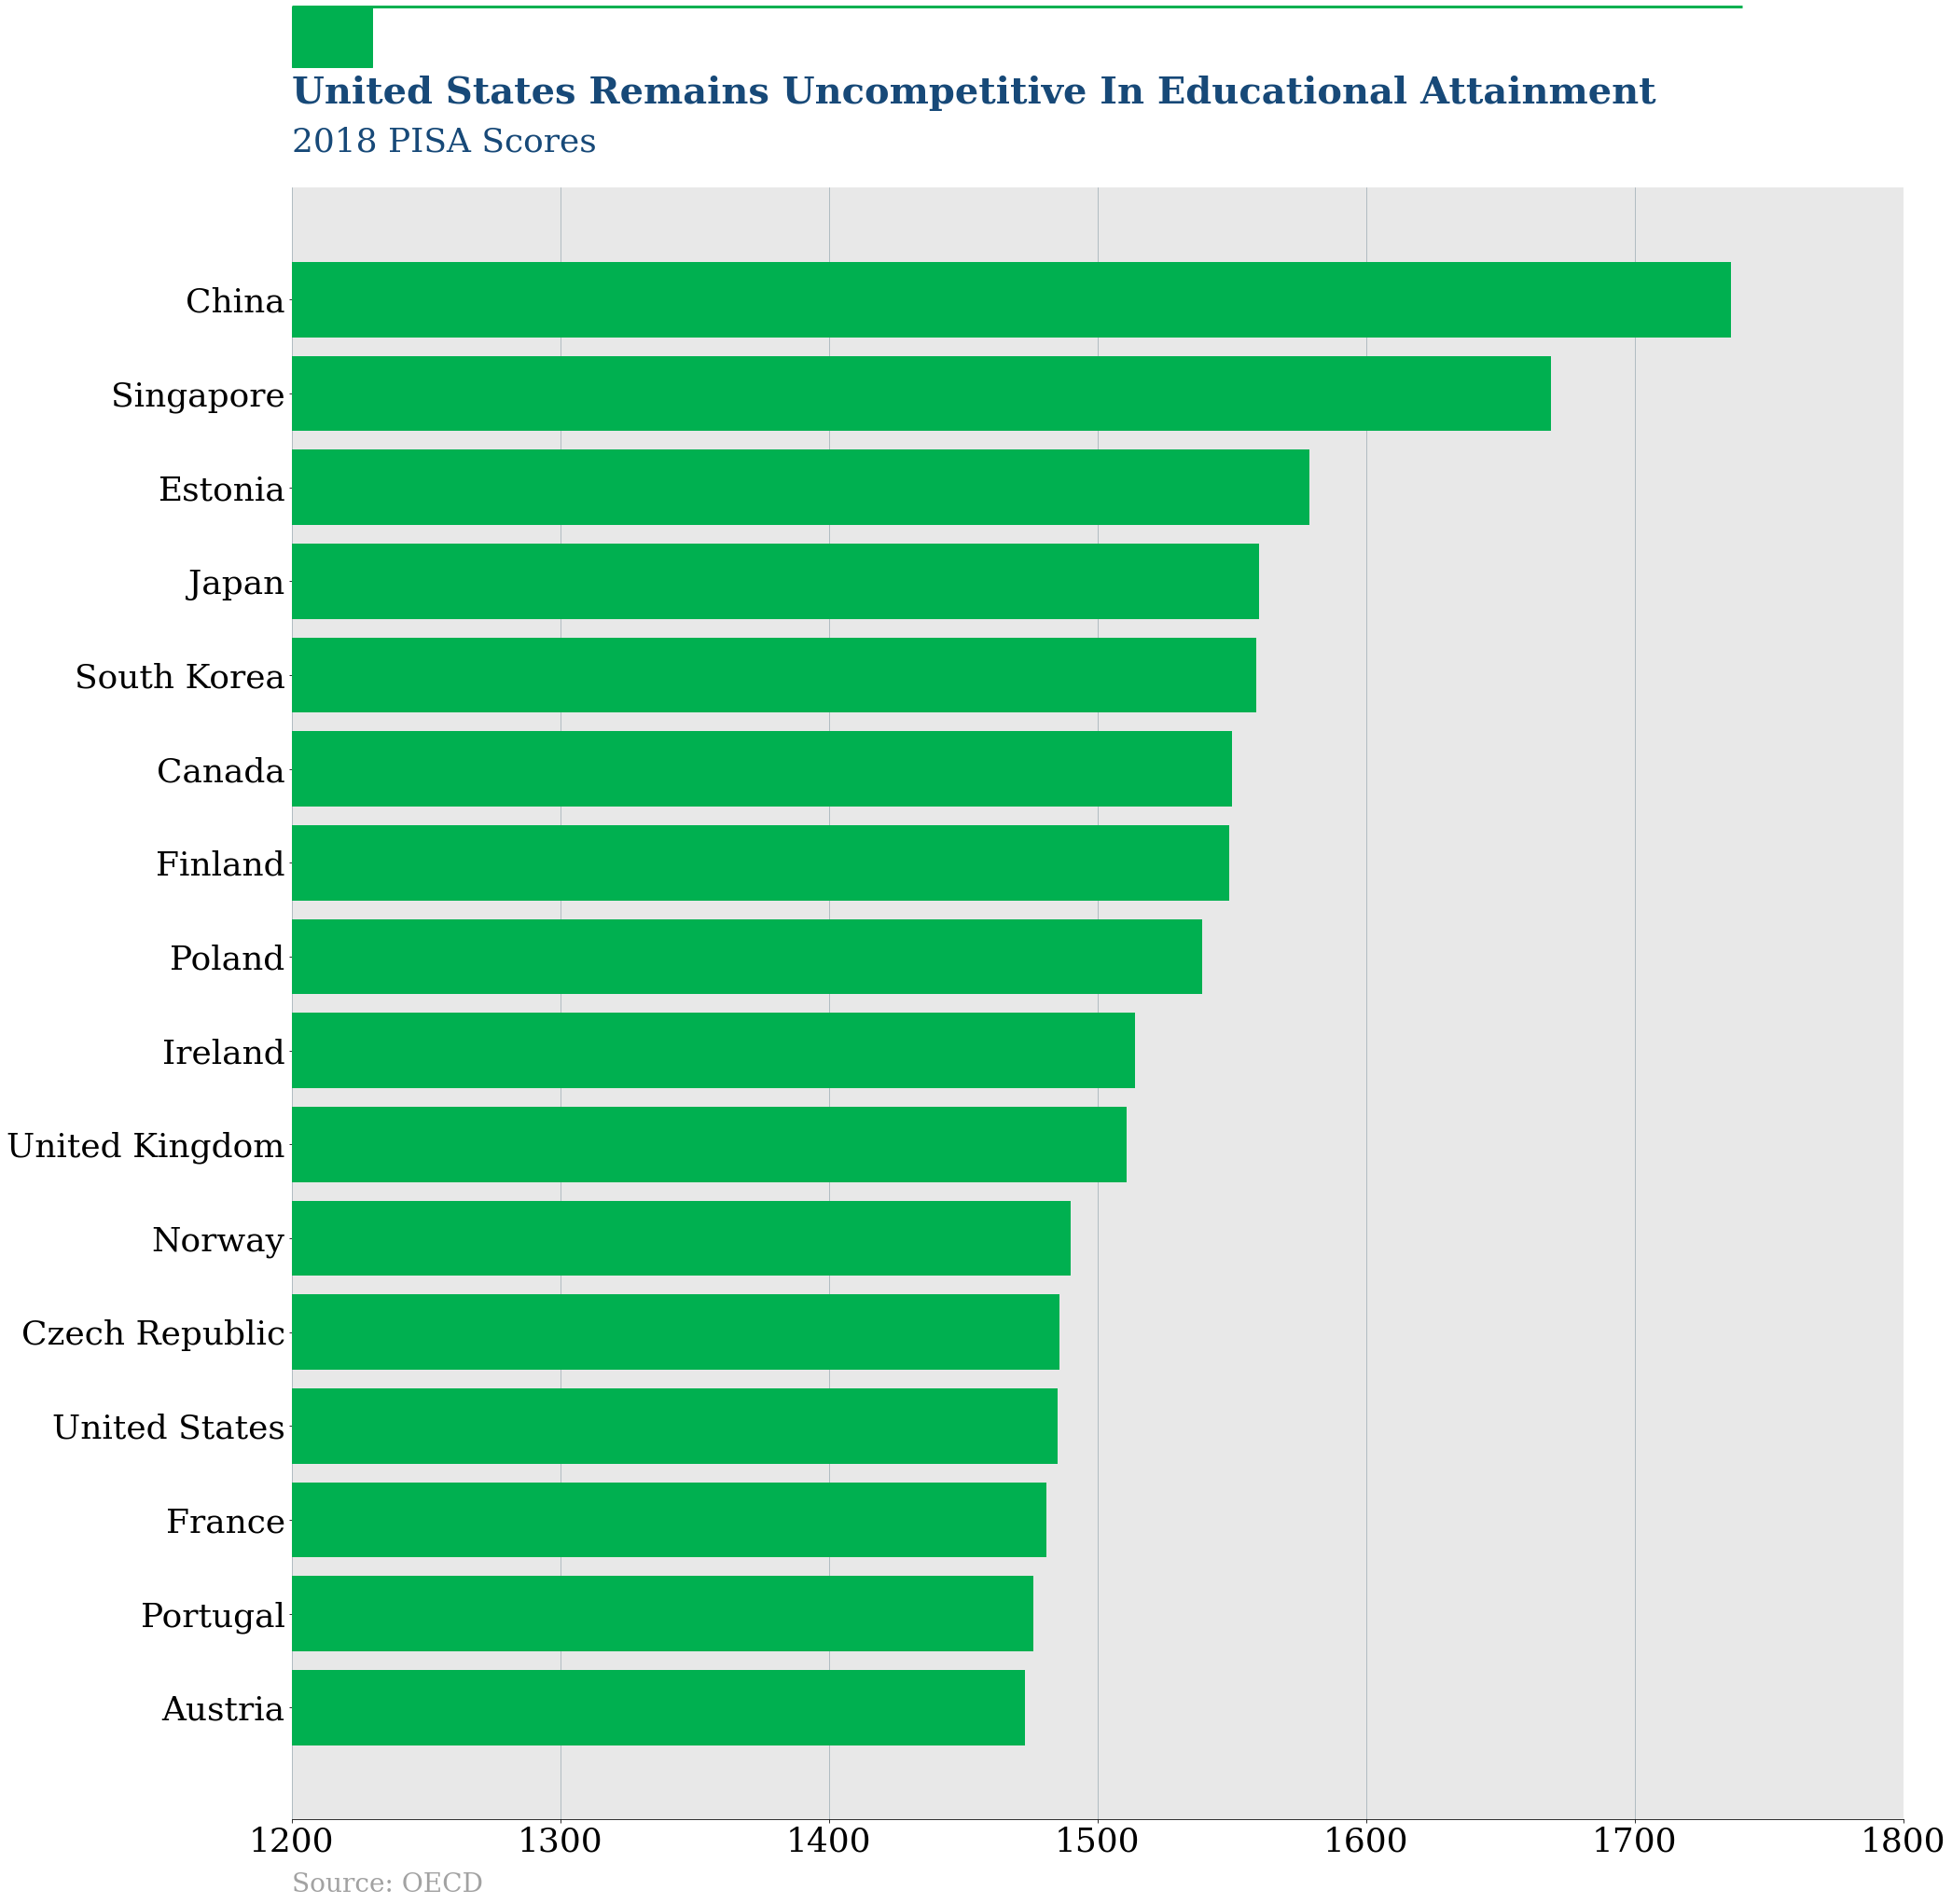

In [14]:
education_df = pd.read_csv('data.csv')

education_df = education_df.drop([education_df.index[10], education_df.index[11],education_df.index[12],education_df.index[13],education_df.index[14],education_df.index[15],education_df.index[16],education_df.index[17]])

countries = education_df['country']
scores = education_df['score']

fig, ax = plt.subplots(1, 1, figsize=(24, 36), sharey=True)
#fig.subplots_adjust(top=0.825, bottom=0.15)
fig.subplots_adjust(left=0, right=1)
ax.set_axisbelow(True)
ax.grid(which="major", axis='x', color='#758D99', alpha=0.6, zorder=1)
ax.barh(countries[::-1], scores[::-1],  color='#00B050')
x_max = 1800
x_min = 1200
# Set y limits
ax.set_xlim(x_min, x_max)  

# Pad between ytick label and y line
ax.xaxis.set_tick_params(labelsize=18*2)
ax.yaxis.set_tick_params(labelsize=18*2)



fig.add_artist(lines.Line2D([0, 1 - 0.1], [1 - 0.1, 1 - 0.1], lw=3, color="#00B050", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975 - 0.1), 0.05, 0.025, color="#00B050"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0, 0.92 - 0.06, "United States Remains Uncompetitive In Educational Attainment", fontsize=40,fontweight="bold")
# Add subtitle
fig.text(0, 0.875 - 0.035, "2018 PISA Scores", fontsize=36)

source = 'Source: OECD'
fig.text(0, 0.12, source, color="#a2a2a2", fontsize=14*2)

plt.savefig('education.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='white') 

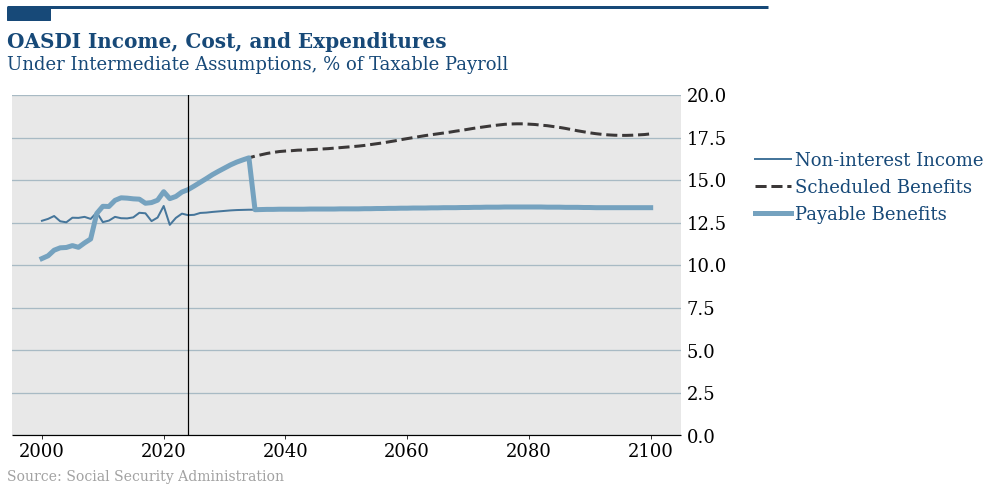

In [15]:
social_df = pd.read_csv('SocialSec.csv')



social_df = social_df.replace('%','', regex=True)
social_df["Income_Rates"] = pd.to_numeric(social_df["Income_Rates"])
social_df["Scheduled"] = pd.to_numeric(social_df["Scheduled"])
social_df["Year"] = pd.to_numeric(social_df["Year"])
social_df["Payable"] = pd.to_numeric(social_df["Payable"])
fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.plot(social_df['Year'], 
        social_df['Income_Rates'], 
        color='#46769b',
        linewidth=2)
ax.plot(social_df['Year'], 
        social_df['Scheduled'],
        linestyle='dashed',
        color='#3B3838',
        linewidth=3)
ax.plot(social_df['Year'], 
        social_df['Payable'], 
        color='#75a2bf',
        linewidth=5)


ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 20)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=2,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 

ax.plot([2024, 2024],[0, 25], color='black', marker='.', ms=10, markevery=[-1], lw=1.2)




source = 'Source: Social Security Administration'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))
ax.legend(['Non-interest Income', 'Scheduled Benefits', 'Payable Benefits'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})

fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "OASDI Income, Cost, and Expenditures", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Under Intermediate Assumptions, % of Taxable Payroll", fontsize=18)
plt.savefig('social_security.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

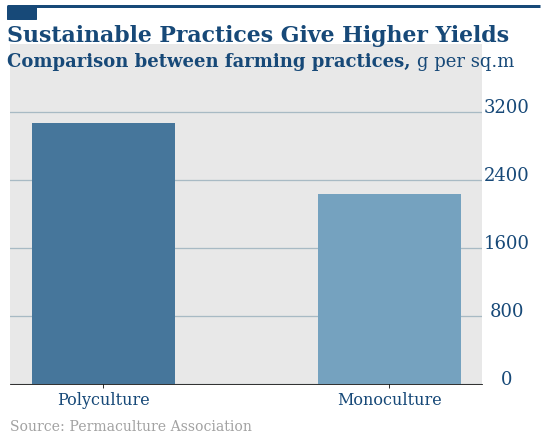

In [16]:
x_axis_names = ['Polyculture', 'Monoculture']
x_axis = np.arange(2)
responses = [3074.8, 2234.9]




x_max = 1.21
y_max = 4000
y_min = 0
number_y_ticks = 5


bar_width = .5
fig, ax = plt.subplots(figsize=(8, 7))
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3, zorder=0)
# first = ax.bar(x_axis, responses, bar_width, color="#174978", zorder=3)
ax.bar(x_axis_names[0], responses[0], bar_width, color='#46769b', zorder=3)
ax.bar(x_axis_names[1], responses[1], bar_width, color='#75a2bf', zorder=3)
ax.set_xticks(x_axis)
ax.xaxis.set_ticklabels(x_axis_names, fontsize=16, fontweight=100, color="#174978")
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_ylim(y_min, y_max)

#plt.setp(autotexts, size=16, weight="bold")
fig.subplots_adjust(top=0.825, bottom=0.15, left=.08)
source = 'Source: Permaculture Association'
fig.text(.08, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([.075, 1], [.9, .9], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((.075, .875), 0.05, 0.025, color="#174978"))

myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0
for label in myticks:
    ax.text(x_max + 0.2, label + PAD, int(label), ha="center", va="baseline", fontsize=18, 
    fontweight=100)
# Add title
fig.text(.075, 0.83, "Sustainable Practices Give Higher Yields", fontsize=22,fontweight="bold")
# Add subtitle
text = "<name:serif, size:18><weight:bold>Comparison between farming practices, </>g per sq.m</>"
flexitext(-.006, .95, text, ax=ax)

plt.savefig('farm.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

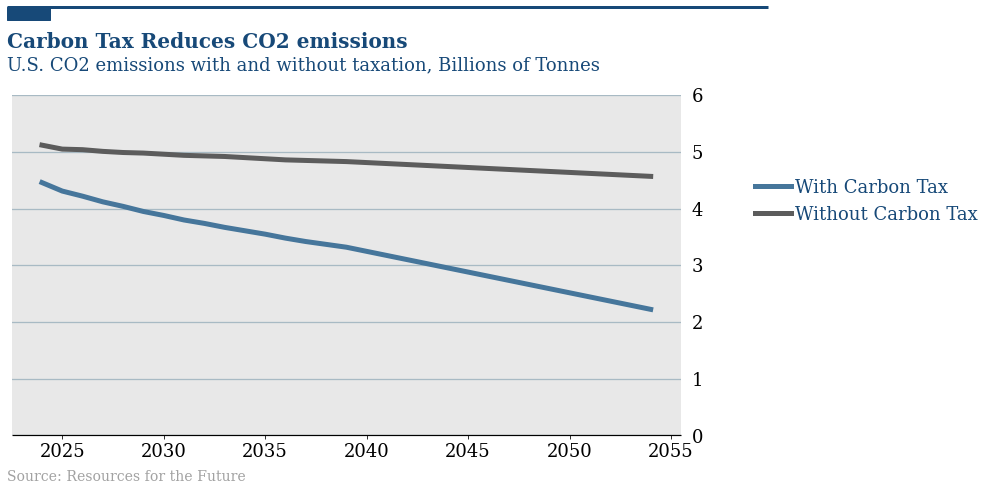

In [29]:
carbon_data = pd.read_csv('carbon.csv')

carbon_data["Taxed Emissions"] = pd.to_numeric(carbon_data["Taxed Emissions"])
carbon_data["Normal Emissions"] = pd.to_numeric(carbon_data["Normal Emissions"])
carbon_data["year"] = pd.to_numeric(carbon_data["year"])

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.plot(carbon_data['year'], 
        carbon_data['Taxed Emissions'], 
        color='#46769b',
        linewidth=5)
ax.plot(carbon_data['year'], 
        carbon_data['Normal Emissions'], 
        color='#5c5c5c',
        linewidth=5)


ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 6)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 





source = 'Source: Resources for the Future'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))
ax.legend(['With Carbon Tax', 'Without Carbon Tax'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})

fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Carbon Tax Reduces CO2 emissions", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "U.S. CO2 emissions with and without taxation, Billions of Tonnes", fontsize=18)
plt.savefig('carbon.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

,Year,Federal,States,Total
0,1978,29803,277473,0.307276
1,1979,26371,288086,0.314457
2,1980,24363,305458,0.329821
3,1981,28133,341797,0.369930
4,1982,29673,384133,0.413806
5,1983,31926,404929,0.436855
6,1984,34263,427739,0.462002
7,1985,40223,462284,0.502507
8,1986,44408,500564,0.544972
9,1987,48300,536784,0.585084


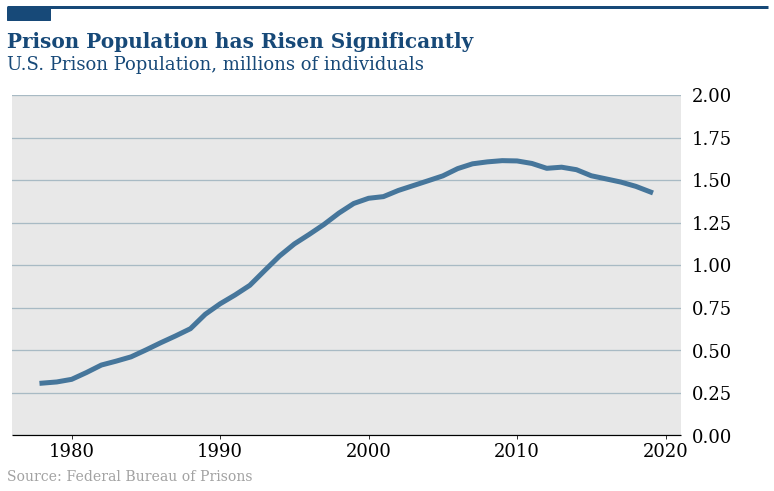

In [31]:
prison_df = pd.read_csv('jurisdiction-population.csv')
prison_df['Total'] = prison_df['Federal'] + prison_df['States']
prison_df['Total'] = prison_df['Total'] /1000000

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)

ax.plot(prison_df['Year'], 
        prison_df['Total'], 
        color='#46769b',
        linewidth=5)




ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 2)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 

source = 'Source: Federal Bureau of Prisons'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)


fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Prison Population has Risen Significantly", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "U.S. Prison Population, millions of individuals", fontsize=18)



plt.savefig('prison.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 







prison_df

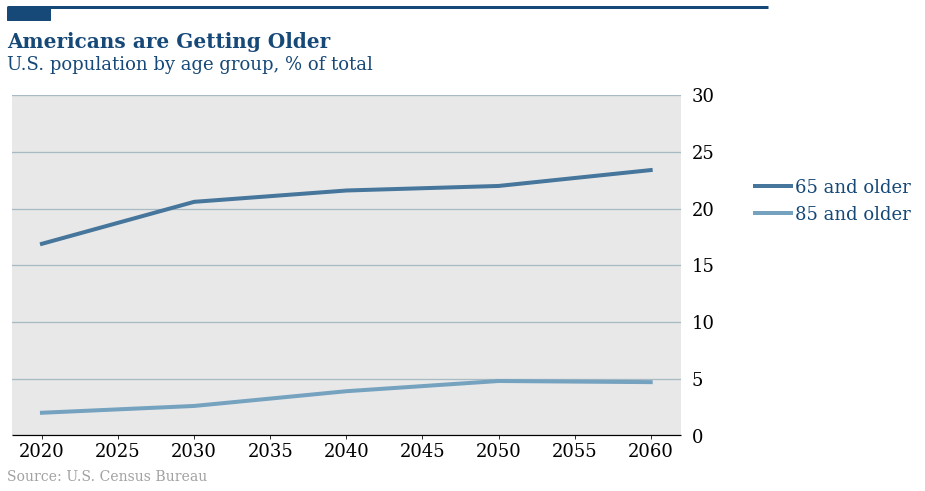

In [19]:
demography_df = pd.read_csv('demography.csv')

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)

ax.plot(demography_df['Year'], 
        demography_df['65+'], 
        color='#46769b',
        linewidth=4)

ax.plot(demography_df['Year'], 
        demography_df['85+'], 
        color='#75a2bf',
        linewidth=4)



ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 30)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 


source = 'Source: U.S. Census Bureau'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

ax.legend(['65 and older', '85 and older'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})
fig.subplots_adjust(top=0.825, bottom=0.15)


fig.text(0.12, 0.92, "Americans are Getting Older", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "U.S. population by age group, % of total", fontsize=18)
plt.savefig('demographics.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

<ipython-input-20-54b69794e6f5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_numbers['Quarter'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[1])
<ipython-input-20-54b69794e6f5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_numbers['Date'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[0])


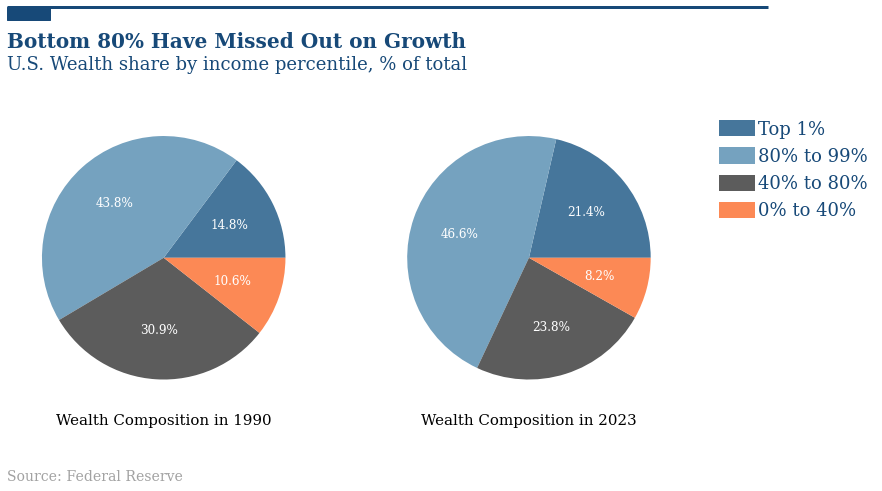

In [20]:
unfiltered_numbers = pd.read_csv('dfa-income-shares.csv')
unfiltered_numbers.keys()
filtered_numbers = unfiltered_numbers[['Date', 'Category', 'Assets']]


filtered_numbers['Quarter'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[1])
filtered_numbers['Date'] = filtered_numbers['Date'].apply(lambda x: x.split(':')[0])
filtered_numbers = filtered_numbers[filtered_numbers['Quarter'] =='Q3']

pct99to100 = filtered_numbers[filtered_numbers['Category'] == 'pct99to100']
pct99to100_l = pct99to100['Assets']

pct80to99 = filtered_numbers[filtered_numbers['Category'] == 'pct80to99']
pct80to99_l = pct80to99['Assets']

pct60to80 = filtered_numbers[filtered_numbers['Category'] == 'pct60to80']
pct60to80_l = pct60to80['Assets']

pct40to60 = filtered_numbers[filtered_numbers['Category'] == 'pct40to60']
pct40to60_l = pct40to60['Assets']

pct20to40 = filtered_numbers[filtered_numbers['Category'] == 'pct20to40']
pct20to40_l = pct20to40['Assets']

pct00to20 = filtered_numbers[filtered_numbers['Category'] == 'pct00to20']
pct00to20_l = pct00to20['Assets']

pct00to40 = pd.DataFrame()
pct00to40['Assets'] = np.array(pct00to20['Assets']) + np.array(pct20to40['Assets'])
pct00to40_l = pct00to40['Assets']

pct40to80 = pd.DataFrame()
pct40to80['Assets'] = np.array(pct40to60['Assets']) + np.array(pct60to80['Assets'])
pct40to80_l = pct40to80['Assets']

top1_1990 = pct99to100[pct99to100['Date'] == '1990']["Assets"].ravel()[0]
top80to99_1990 = pct80to99[pct80to99['Date'] == '1990']["Assets"].ravel()[0]
top40to80_1990 = pct60to80[pct60to80['Date'] == '1990']["Assets"].ravel()[0] + pct40to60[pct40to60['Date'] == '1990']["Assets"].ravel()[0]
top0to40_1990 = pct00to20[pct00to20['Date'] == '1990']["Assets"].ravel()[0] + pct20to40[pct20to40['Date'] == '1990']["Assets"].ravel()[0]
values_1990 = [top1_1990, top80to99_1990, top40to80_1990, top0to40_1990]
labels = ["Top 1%", "80% to 99%", "40% to 80%", "0% to 40%"]
fig, axs = plt.subplots(1, 2, figsize=figsize)

top1_2023 = pct99to100[pct99to100['Date'] == '2023']["Assets"].ravel()[0]
top80to99_2023 = pct80to99[pct80to99['Date'] == '2023']["Assets"].ravel()[0]
top40to80_2023 = pct60to80[pct60to80['Date'] == '2023']["Assets"].ravel()[0] + pct40to60[pct40to60['Date'] == '2023']["Assets"].ravel()[0]
top0to40_2023 = pct00to20[pct00to20['Date'] == '2023']["Assets"].ravel()[0] + pct20to40[pct20to40['Date'] == '2023']["Assets"].ravel()[0]
values_2023 = [top1_2023, top80to99_2023, top40to80_2023, top0to40_2023]



axs[0].pie(values_1990, colors = ["#46769b", "#75a2bf", "#5c5c5c", "#FC8955"], autopct = '%1.1f%%', textprops={'color':"w", 'size':"12"})
axs[0].set_xlabel('Wealth Composition in 1990', fontsize = 15)

axs[1].pie(values_2023, colors = ["#46769b", "#75a2bf", "#5c5c5c", "#FC8955"], autopct = '%1.1f%%', textprops={'color':"w", 'size':"12"})
axs[1].set_xlabel('Wealth Composition in 2023', fontsize = 15)


axs[1].legend(["Top 1%", "80% to 99%", "40% to 80%", "0% to 40%"], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})

source = 'Source: Federal Reserve'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

fig.text(0.12, 0.92, "Bottom 80% Have Missed Out on Growth", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "U.S. Wealth share by income percentile, % of total", fontsize=18)

plt.savefig('wealth.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

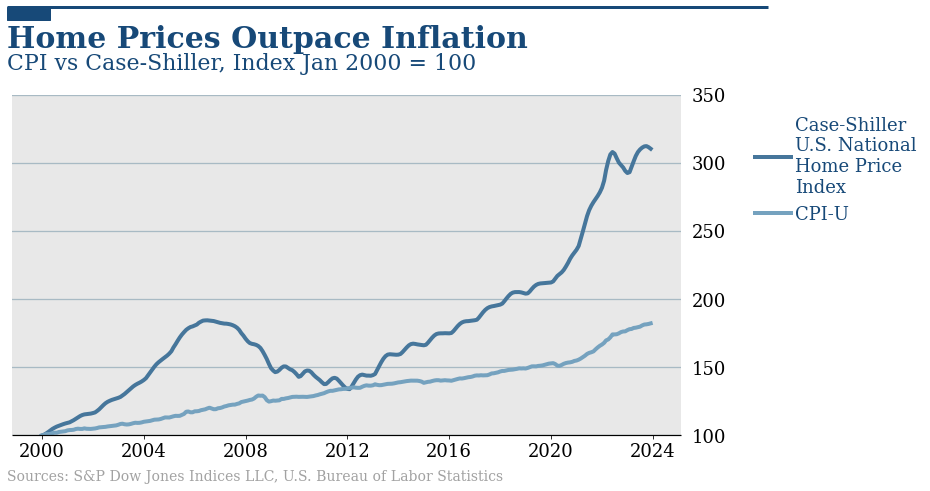

In [21]:
housing_df = pd.read_csv("housing.csv")
housing_df.drop(housing_df.tail(1).index,inplace=True)

housing_df["CPIAUCSL_NBD20000101"] = pd.to_numeric(housing_df["CPIAUCSL_NBD20000101"])
housing_df["CSUSHPINSA"] = pd.to_numeric(housing_df["CSUSHPINSA"])
housing_df["DATE"] = pd.to_datetime(housing_df["DATE"])

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)

ax.plot(housing_df['DATE'], 
        housing_df['CSUSHPINSA'], 
        color='#46769b',
        linewidth=4)

ax.plot(housing_df['DATE'], 
        housing_df['CPIAUCSL_NBD20000101'], 
        color='#75a2bf',
        linewidth=4)

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(100, 350)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 

source = 'Sources: S&P Dow Jones Indices LLC, U.S. Bureau of Labor Statistics'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

ax.legend(['Case-Shiller\nU.S. National\nHome Price\nIndex', 'CPI-U'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})
fig.subplots_adjust(top=0.825, bottom=0.15)


fig.text(0.12, 0.92, "Home Prices Outpace Inflation", fontsize=30,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "CPI vs Case-Shiller, Index Jan 2000 = 100", fontsize=22)
plt.savefig('housing.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 


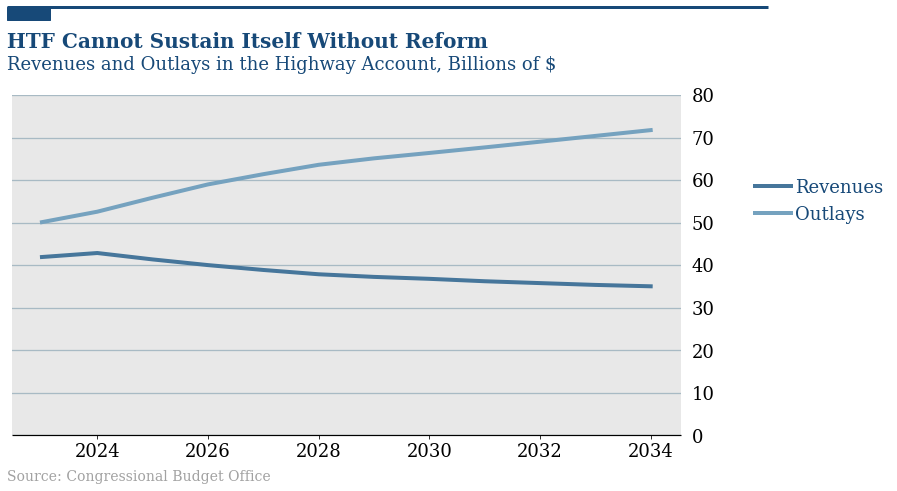

In [22]:
transit_df = pd.read_csv('transit.csv')


transit_df["Outlay"] = pd.to_numeric(transit_df["Outlay"])
transit_df["Revenue"] = pd.to_numeric(transit_df["Revenue"])


transit_df["Outlay"] = transit_df["Outlay"] / 1000
transit_df["Revenue"] = transit_df["Revenue"] / 1000

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)


ax.plot(transit_df['Date'], 
        transit_df['Revenue'], 
        color='#46769b',
        linewidth=4)

ax.plot(transit_df['Date'], 
        transit_df['Outlay'], 
        color='#75a2bf',
        linewidth=4)

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 80)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 


source = 'Source: Congressional Budget Office'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

ax.legend(['Revenues', 'Outlays'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})
fig.subplots_adjust(top=0.825, bottom=0.15)


fig.text(0.12, 0.92, "HTF Cannot Sustain Itself Without Reform", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Revenues and Outlays in the Highway Account, Billions of $", fontsize=18)
plt.savefig('transit.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

Index(['year', 'OASI ', 'DI', 'OASDI '], dtype='object')


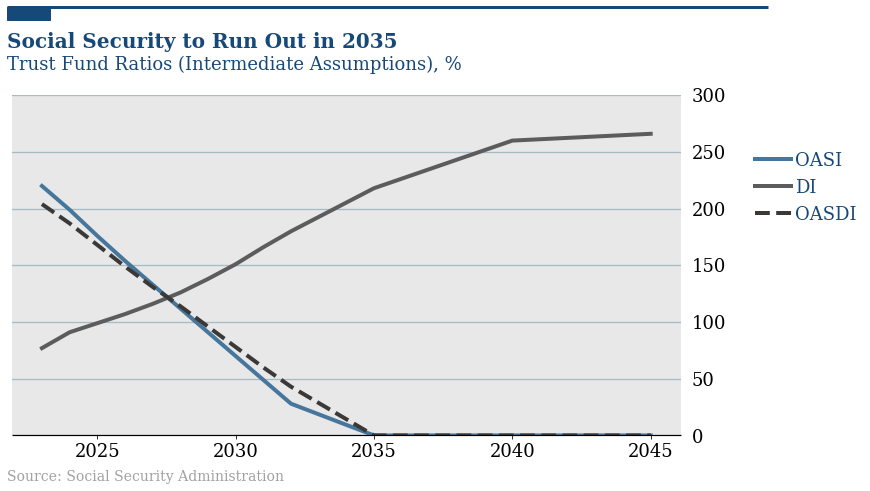

In [23]:
social_df = pd.read_csv('social.csv')

social_df.drop(social_df.tail(11).index,inplace=True)
print(social_df.keys())


fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
# ax.grid(which="major", axis='y', color='#758D99', alpha=0.6, zorder=1)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)


ax.plot(social_df['year'], 
        social_df['OASI '], 
        color='#46769b',
        linewidth=4)

ax.plot(social_df['year'], 
        social_df['DI'], 
        color='#5c5c5c',
        linewidth=4)

ax.plot(social_df['year'], 
        social_df['OASDI '], 
        linestyle='dashed',
        color='#3B3838',
        linewidth=4)

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.set_ylim(0, 300)

ax.xaxis.set_tick_params(labelsize=18)



ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 


source = 'Source: Social Security Administration'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

ax.legend(['OASI', 'DI', 'OASDI'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})
fig.subplots_adjust(top=0.825, bottom=0.15)


fig.text(0.12, 0.92, "Social Security to Run Out in 2035", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Trust Fund Ratios (Intermediate Assumptions), %", fontsize=18)
plt.savefig('social_sec.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

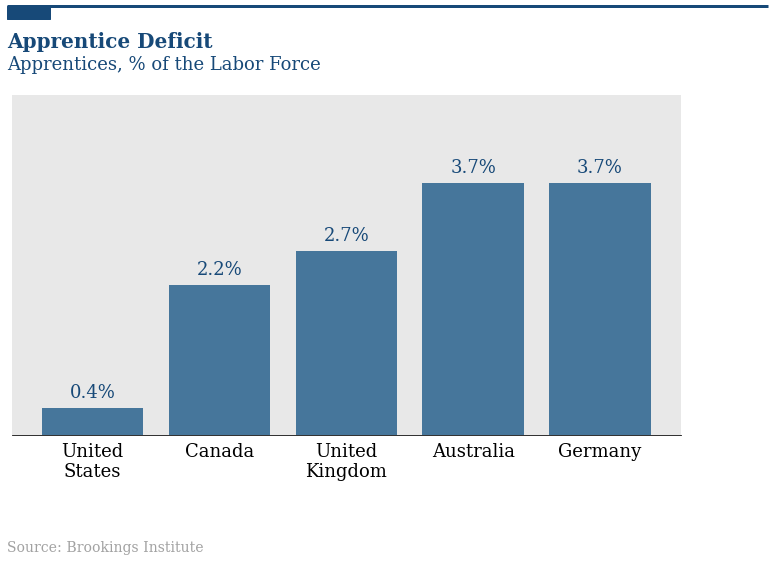

In [24]:
countries = ['United\nStates', 'Canada', 'United\nKingdom', 'Australia', 'Germany']
values = [0.4, 2.2, 2.7, 3.7, 3.7]

fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)



ax.bar(countries, values,  color='#46769b')


ax.set_ylim(0, 5)

ax.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = True, bottom = False)

ax.xaxis.set_tick_params(labelsize=18)

rects = ax.patches
labels = ['0.4%', '2.2%', '2.7%', '3.7%', '3.7%']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.1, label, ha="center", va="bottom", fontsize = 18
    )


source = 'Source: Brookings Institute'
fig.text(0.12, -0.08, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Apprentice Deficit", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Apprentices, % of the Labor Force", fontsize=18)

plt.savefig('apprentice.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

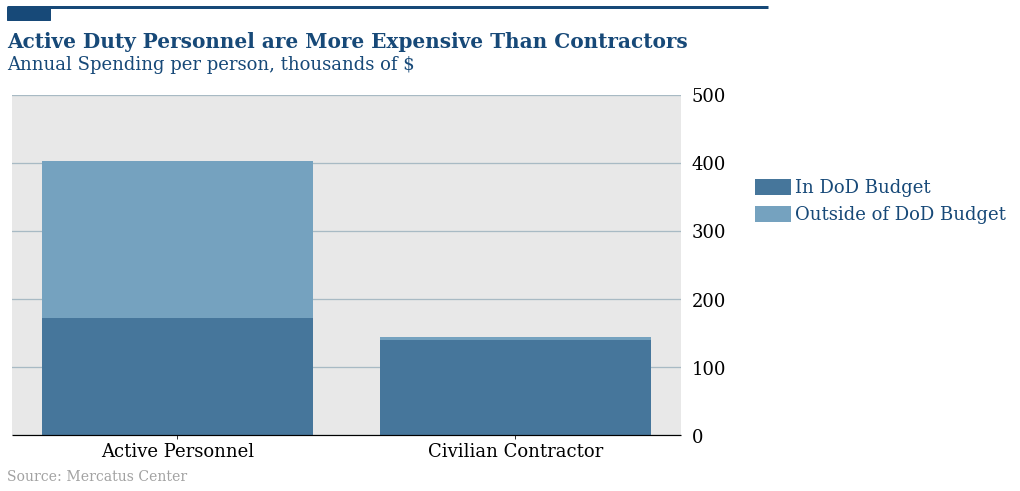

In [25]:
x = ['Active Personnel', 'Civilian Contractor']
in_dod = np.array([173.272, 140.052])
non_dod = np.array([230.638, 5.280])


fig, ax = plt.subplots(1, 1, figsize=figsize)
ax.set_axisbelow(True)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
ax.bar(x, in_dod, color='#46769b')
ax.bar(x, non_dod, bottom=in_dod, color='#75a2bf')

ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")

ax.yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18) 

ax.set_ylim(0, 500)

ax.xaxis.set_tick_params(labelsize=18)

source = 'Source: Mercatus Center'
fig.text(0.12, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([0.12, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0.12, 0.975), 0.05, 0.025, color="#174978"))

ax.legend(['In DoD Budget', 'Outside of DoD Budget'], loc=(1.1,0.6), ncol=1, frameon=False, handletextpad=.2, handleheight=1, prop={'size': 18})


fig.subplots_adjust(top=0.825, bottom=0.15)
fig.text(0.12, 0.92, "Active Duty Personnel are More Expensive Than Contractors", fontsize=20,fontweight="bold")
# Add subtitle
fig.text(0.12, 0.875, "Annual Spending per person, thousands of $", fontsize=18)

plt.savefig('defense.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

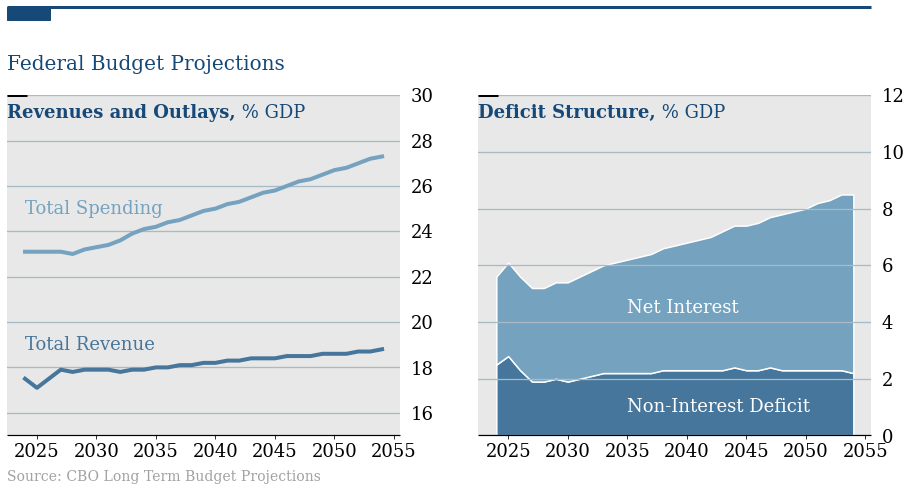

In [26]:
budget_df = pd.read_csv('budget-gdp.csv')

fig, axes = plt.subplots(1, 2, figsize=figsize)
fig.subplots_adjust(left=0, right=1)

axes[0].grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)


axes[0].plot(budget_df['Year'], 
        budget_df['Revenues'], 
        color='#46769b',
        linewidth=4)

axes[0].plot(budget_df['Year'], 
        budget_df['Total Spending'], 
        color='#75a2bf',
        linewidth=4)

axes[0].spines["bottom"].set_lw(1.2)
axes[0].spines["bottom"].set_capstyle("butt")

axes[0].set_ylim(15, 30)

axes[0].xaxis.set_tick_params(labelsize=18)



axes[0].yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18)

text = "<name:serif, size:18><weight:bold>Revenues and Outlays,</> % GDP</>"
flexitext(0, 0.975, text, va="top", ax=axes[0])



axes[0].add_artist(lines.Line2D([0, 0.05], [1, 1], lw=3, color="black", solid_capstyle="butt", transform=axes[0].transAxes))

labels = [
    {"x": 2024, "y": 25, "text": 'Total Spending', "color": "#75a2bf", "path_effects":[], 'rotation':0},
    {"x": 2024, "y": 19, "text": "Total Revenue", "color": "#46769b", "path_effects":[], 'rotation':0}] 

for label in labels:
    add_label(**label, ax=axes[0])




axes[1].grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)

axes[1].spines["bottom"].set_lw(1.2)
axes[1].spines["bottom"].set_capstyle("butt")

axes[1].set_ylim(0, 12)

axes[1].xaxis.set_tick_params(labelsize=18)


axes[1].yaxis.set_tick_params(pad=7,             # Pad tick labels so they don't go over y-axis
                         labeltop=True,      # Put x-axis labels on top
                         labelbottom=False,  # Set no x-axis labels on bottom
                         bottom=False,       # Set no ticks on bottom
                         labelsize=18)

axes[1].stackplot(budget_df['Year'], [budget_df['Normal Deficit'], budget_df['Net Interest']], colors=["#46769b", "#75a2bf"], lw=1.5, edgecolor='white')

text = "<name:serif, size:18><weight:bold>Deficit Structure,</> % GDP</>"
flexitext(0, 0.975, text, va="top", ax=axes[1])



axes[1].add_artist(lines.Line2D([0, 0.05], [1, 1], lw=3, color="black", solid_capstyle="butt", transform=axes[1].transAxes))

labels = [
    {"x": 2035, "y": 1, "text": "Non-Interest Deficit", "color": 'white', "path_effects":[], 'rotation':0},
    {"x": 2035, "y": 4.5, "text": "Net Interest", "color": "white", "path_effects":[], 'rotation':0}]    

for label in labels:
    add_label(**label, ax=axes[1])

fig.subplots_adjust(top=0.825, bottom=0.15)

source = 'Source: CBO Long Term Budget Projections'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14)
    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1], [1, 1], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975), 0.05, 0.025, color="#174978"))

# Add title

# Add subtitle
fig.text(0, 0.875, "Federal Budget Projections", fontsize=20)

plt.savefig('bleak_future.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

    Year  Old Debt to GDP Ratio  New Debt to GDP Ratio  \
0   2024                 99.013                  99.05   
1   2025                101.693                  99.02   
2   2026                103.321                  97.94   
3   2027                104.658                  96.73   
4   2028                106.355                  95.46   
5   2029                107.401                  94.43   
6   2030                108.744                  93.45   
7   2031                110.206                  92.82   
8   2032                111.904                  92.22   
9   2033                114.063                  91.95   
10  2034                115.994                  91.80   
11  2035                117.970                  91.79   
12  2036                120.001                  91.94   
13  2037                122.104                  92.11   
14  2038                124.292                  92.40   
15  2039                126.540                  92.85   
16  2040      

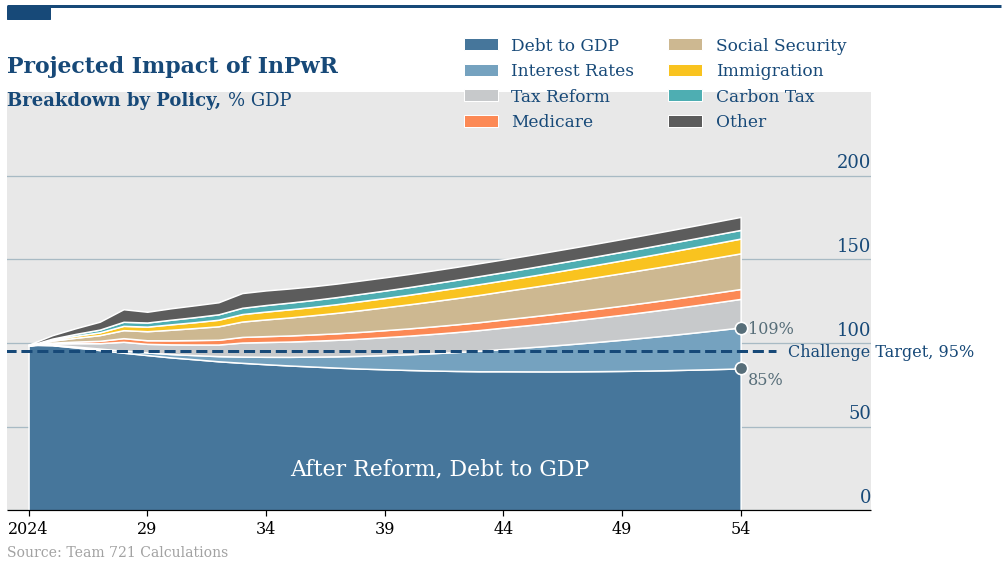

In [27]:
from matplotlib import patches
final_df = pd.read_csv('policy-nums-2024.csv')
final_df = final_df.replace('%','', regex=True)
cols = final_df.columns
final_df[cols] = final_df[cols].apply(pd.to_numeric, errors='coerce')
print(final_df)

policies = ['Social Security',
            'Mortgage Interest',
            '45% Rate',
            'IRS Funding',
            'Farm Policy',
            'Carbon Tax',
            'Transit',
            'Prison',	
            'Medicare',	
            'Military',	
            'Immigration',	
            'Housing']

for policy in policies:
    final_df[policy] = final_df[policy] * -1

old = final_df['Old Debt to GDP Ratio']
new = final_df['New Debt to GDP Ratio'] 
new_i = final_df['New Debt to GDP Ratio Interest']

tax = (final_df['45% Rate'] + final_df['Mortgage Interest'] + final_df['IRS Funding'])
other = (final_df['Transit'] + final_df['Housing'] + final_df['Military'] + final_df['Prison'] + final_df['Farm Policy'])



dates = final_df['Year']
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.bottom'] = True

fig, ax = plt.subplots(figsize=figsize)
fig.subplots_adjust(left=0, right=1)
data = [new_i] + [final_df['Interest Rate']] + [tax] + [final_df['Medicare']] + [final_df['Social Security']] + [final_df['Immigration']] + [final_df['Carbon Tax']] + [other]

BROWN = "#AD8C97"
BROWN_DARKER = "#7d3a46"
GREEN = "#2FC1D3"
BLUE = "#076FA1"
GREY = "#C7C9CB"
GREY_DARKER = "#5C5B5D"
RED = "#E3120B"
YELLOW = '#F9C31F'
MIDGREEN = '#91b8bd'
GRIDLINE_COLOR = "#A8BAC4"

color1 = '#9ae5de'

BEIGE = '#efe8d1'

REAL_GREEN = '#379A8B'

COLORS = ["#46769b", "#75a2bf", GREY, "#FC8955", '#cdb891', YELLOW, "#4EAEB2", "#5c5c5c"]
## Create our axes with the correct tiksetup for both charts
n_ticks = 5
x_max = 2059.5
number_y_ticks = 5

ax.set_axisbelow(True)
# Format X and Y ticks 
# We only only want every fourth tick
dateticks = dates[0::n_ticks]
ax.xaxis.set_ticks(dateticks)
label_dates = [2024] + [int(float(str(mydate)[2:])) for mydate in dateticks if mydate != 2024]
ax.xaxis.set_ticklabels(label_dates, fontsize=16, fontweight=100)
ax.xaxis.set_tick_params(length=6, width=1.2)
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3)
# Remove all spines but the one in the bottom
# Customize bottom spine
# We want to make the bottom spine bolder.
ax.spines["bottom"].set_lw(1.2)
ax.spines["bottom"].set_capstyle("butt")
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_xlim(2023.1, x_max)

## Chart Two

ax.stackplot(dates, data, colors=COLORS, lw=1.5, edgecolor='white')
y_max = 250
y_min = 0
# Set y limits
ax.set_ylim(y_min, y_max)  
myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0.02
for label in myticks:
    ax.text(x_max, label + PAD, int(label), ha="right", va="baseline", fontsize=18, 
    fontweight=100)



## Add in sources 
#fig.subplots_adjust(top=0.825, bottom=0.15)

source = 'Source: Team 721 Calculations'
fig.text(0, 0.06, source, color="#a2a2a2", fontsize=14)
    
# Add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1 + 0.15], [1+ 0.15, 1+ 0.15], lw=3, color='#174978', solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 0.975+ 0.15), 0.05, 0.025, color='#174978'))

# Add title
fig.text(0, 0.92+ 0.1, "Projected Impact of InPwR", fontsize=22,fontweight="bold")
# Add subtitle

ax.plot([2023, 2055.5],[95, 95], color="#174978", lw=3, linestyle = 'dashed')

ax.text(2056, 95, 
        'Challenge Target, 95%', 
        color="#174978",
        fontsize=16, 
        va="center", 
        ha="left",  
        rotation=0)


COLORS = ["#46769b", "#75a2bf", GREY, "#FC8955", '#cdb891', YELLOW, "#4EAEB2", "#5c5c5c"]
legend_elements = [patches.Patch(facecolor='#46769b', edgecolor='white', label='Debt to GDP'),
                   patches.Patch(facecolor='#75a2bf', edgecolor='white', label='Interest Rates'),
                   patches.Patch(facecolor=GREY, edgecolor='white', label='Tax Reform'),
                   patches.Patch(facecolor='#FC8955', edgecolor='white', label='Medicare'),
                   patches.Patch(facecolor='#cdb891', edgecolor='white', label='Social Security'),
                   patches.Patch(facecolor=YELLOW, edgecolor='white', label='Immigration'),
                   patches.Patch(facecolor="#4EAEB2", edgecolor='white', label='Carbon Tax'),
                   patches.Patch(facecolor="#5c5c5c", edgecolor='white', label='Other')]

# Create the figure
ax.legend(handles=legend_elements, loc='center', ncol=2, fontsize=17, frameon=False, bbox_to_anchor=(.75, 0.92+ 0.1))


text = "<name:serif, size:18><weight:bold>Breakdown by Policy, </>% GDP</>"
flexitext(0, 0.88 + 0.1, text, ax=ax)

labels = [{"x": 2035, "y": 25, "text": "After Reform, Debt to GDP", "color": "white", "path_effects":[], 'rotation':0}]
  

for label in labels:
    add_label(**label, ax=ax, fontsize=22)

fig.subplots_adjust(top=0.98, bottom=0.15)

final_debt_gdp = round(new_i.iloc[len(new_i) - 1])

ax.text(2054.3, final_debt_gdp - 7, 
        '85' + '%', 
        color='#576E79',
        fontsize=16, 
        va="center", 
        ha="left",  
        rotation=0)

ax.scatter([2054, 2054], [final_debt_gdp, final_debt_gdp],  fc='#576E79', s=150, lw=1.5, ec="white", zorder=12)

final_debt_gdp = round(new.iloc[len(new) - 1])

ax.text(2054.3, final_debt_gdp - .2, 
        str(final_debt_gdp) + '%', 
        color='#576E79',
        fontsize=16, 
        va="center", 
        ha="left",  
        rotation=0)

ax.scatter([2054, 2054], [final_debt_gdp, final_debt_gdp],  fc='#576E79', s=150, lw=1.5, ec="white", zorder=12)


plt.savefig('final-2024.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 

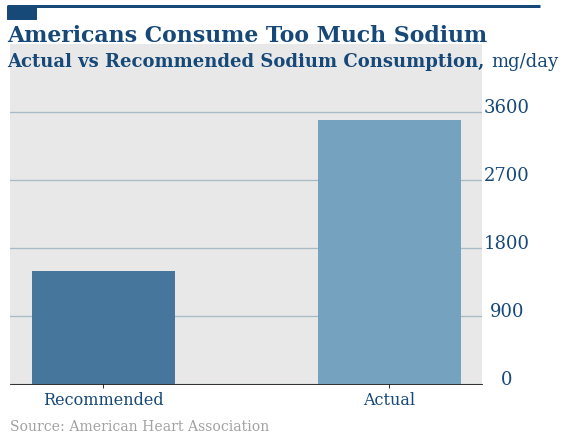

In [28]:
x_axis_names = ['Recommended', 'Actual']
x_axis = np.arange(2)
responses = [1500, 3500]




x_max = 1.21
y_max = 4500
y_min = 0
number_y_ticks = 5


bar_width = .5
fig, ax = plt.subplots(figsize=(8, 7))
ax.grid(axis="y", color=GRIDLINE_COLOR, lw=1.3, zorder=0)
# first = ax.bar(x_axis, responses, bar_width, color="#174978", zorder=3)
ax.bar(x_axis_names[0], responses[0], bar_width, color='#46769b', zorder=3)
ax.bar(x_axis_names[1], responses[1], bar_width, color='#75a2bf', zorder=3)
ax.set_xticks(x_axis)
ax.xaxis.set_ticklabels(x_axis_names, fontsize=16, fontweight=100, color="#174978")
ax.yaxis.set_tick_params(labelleft=False, length=0)
ax.set_ylim(y_min, y_max)

#plt.setp(autotexts, size=16, weight="bold")
fig.subplots_adjust(top=0.825, bottom=0.15, left=.08)
source = 'Source: American Heart Association'
fig.text(.08, 0.06, source, color="#a2a2a2", fontsize=14)

fig.add_artist(lines.Line2D([.075, 1], [.9, .9], lw=3, color="#174978", solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((.075, .875), 0.05, 0.025, color="#174978"))

myticks = create_yticks(y_min, y_max, number_y_ticks)
# Setting the yticks are important for formatting further down
ax.yaxis.set_ticks(myticks)
# Pad between ytick label and y line
PAD = y_max * 0
for label in myticks:
    ax.text(x_max + 0.2, label + PAD, int(label), ha="center", va="baseline", fontsize=18, 
    fontweight=100)
# Add title
fig.text(.075, 0.83, "Americans Consume Too Much Sodium", fontsize=22,fontweight="bold")
# Add subtitle
text = "<name:serif, size:18><weight:bold>Actual vs Recommended Sodium Consumption, </>mg/day</>"
flexitext(-.006, .95, text, ax=ax)

plt.savefig('sodium.png',    # Set path and filename
            dpi = 300,                     # Set dots per inch
            bbox_inches="tight",           # Remove extra whitespace around plot
            facecolor='#e8e8e8') 